In [1]:
from util import *
df = load_bout()
df['level'] = [1 if val > 150 else 0 for val in df['step']]
users = getSortedUser(df)
n_user = len(users)
bout_ratio = getBoutRatio(df)

In [2]:
color['all'] = 'tab:olive'
def plot_scale_hour(name, df_, scale_type = 'nbout'):
    # display(pd.concat([getBoutRatio(df_.query(f"uid == @name and level == @level"), normalize = False) for level in range(2)],keys=["low_level","high_level"]))
    fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (24, 7.2), sharex = True, sharey= 'col')
    for idx, btype in enumerate(["phone","watch","both", "all"]):
        for ldx, level in enumerate(["Low","High"]):
            data = df_.query(f"uid == @name and level == @ldx")
            if btype!= "all":
                data = data.query(f"btype == '{btype[0]}'")
            data = data.groupby(["hour"]).agg(nbout = ("step", "count"), step = ("step","sum"))
            data = data.reindex(np.arange(24), fill_value = 0)
            axes[idx][ldx].bar(x = np.arange(0,24), height = data[scale_type].to_numpy(), color = color[btype])           
            
            axes[idx][ldx].set_xlabel(f"{btype} bout, {level} level, {scale_type}")
            axes[idx][ldx].set_xticks(np.arange(0,24,3))
            axes[idx][ldx].set_xticklabels([str(jdx*3).zfill(2) for jdx in range(8)])                                    
    plt.tight_layout()
    plt.show()

In [4]:
color['all'] = 'tab:olive'
def plot_scale_hour_noagg(name, df_):
    udf = df_.query(f"uid == @name")
    ndate = len(set(udf['date']))
    for date in sorted(set(udf['date'])):
        fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (24, 4.8), sharex = True, sharey= 'col')
        fig.suptitle(date)
        for ldx, level in enumerate(["Low","High"]):
            for idx, stype in enumerate(["nbout","step"]):
                bottom = np.zeros(24)
                for bdx, btype in enumerate(["both","phone","watch"]):
                    data = udf.query(f"level == @ldx and date == @date")
                    if btype!= "all":
                        data = data.query(f"btype == '{btype[0]}'")
                    data = data.groupby(["hour"]).agg(nbout = ("step", "count"), step = ("step","sum"))
                    data = data.reindex(np.arange(24), fill_value = 0)
                    axes[ldx][idx].bar(x = np.arange(0,24), height = data[stype].to_numpy(), color = color[btype])
                    bottom += data[stype].to_numpy()

                axes[ldx][idx].set_xlabel(f"{level} level, {stype}")
                axes[ldx][idx].set_xticks(np.arange(0,24,3))
                axes[ldx][idx].set_xticklabels([str(jdx*3).zfill(2) for jdx in range(8)])                                    
        plt.tight_layout()
        plt.show()
        plt.close()

In [5]:
df["is_day"] = [1 if 6 <= val < 18 else 0 for val in df["hour"].to_numpy()]
df["is_weekend"] = [1 if val >= 5 else 0 for val in df['date'].dt.weekday.to_numpy()]
total_diff= np.sum(np.abs(df["pstep"].to_numpy() - df["wstep"].to_numpy()))

In [6]:
def filterWearingHour(df, ret_wearing = True):
    tmp = df.groupby(["uid", "date", "hour","btype"]).agg(step = ("step","sum"))
    tmp = tmp.unstack(level=3, fill_value = 0)
    tmp.columns = ['b','p','w']
    tmp = tmp.apply(lambda x: x/np.sum(x),axis = 1)
    if ret_wearing:
        tmp = tmp.query("p < 0.95 and w < 0.95")
    else:
        tmp = tmp.query("p >= .95 or w >= .95 ")
    df_ = df.set_index(["uid","date","hour"])
    df_ = df_[df_.index.isin(tmp.index)]
    df_ =df_.reset_index()
    return df_

In [7]:
def make_hourly(df):
    hourly_ = df.groupby(["uid","date","hour","btype"]).agg(step = ("step","sum"))
    hourly_ = hourly_.unstack(level = 3, fill_value = 0)
    hourly_.columns = ["b","p","w"]
    hourly_ = hourly_.apply(lambda x: np.concatenate((x/np.sum(x), x, np.sum(x).reshape(1))),axis = 1,  result_type='expand')
    hourly_.columns = ['bratio','pratio','wratio','bstep','pstep','wstep','sum']
    tmp = list(set(hourly_.reset_index().set_index(["uid","date"]).index))
    index = []
    for uid, ts in tmp:
        for i in range(24):
            index.append((uid, ts,i)) 
    hourly_ = hourly_.reindex(pd.MultiIndex.from_tuples(index, names = ["uid","date","hour"]), fill_value = 0)
    hourly_['level'] = ['inactive' if val == 0 else ('sedentary' if val < 50  else ('little' if val < 200 else ('moderate' if val <650 else 'vigorous'))) for val in hourly_['sum'].to_numpy()]
    hourly_ = hourly_.reset_index().sort_values(by= ['uid','date','hour'])
    return hourly_ 

sedentary: 1.1 1.0
little: 2.5 3.8
moderate: 4.3 7.6
vigorous: 10.4 14.3
total: 18.3 26.7


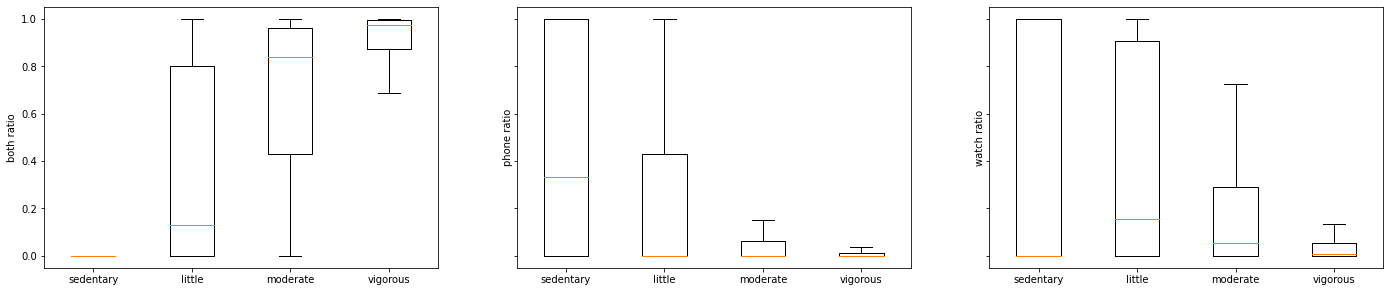

In [15]:
levels = ["sedentary","little","moderate","vigorous"]
# 50, 200, 650 
hourly=  filterWearingDate(df)
hourly = make_hourly(hourly)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 4.8), sharex = True, sharey= 'row')
for idx, btype in enumerate(["both","phone","watch"]):
    axes[idx].boxplot([hourly.query("level == @level")[f"{btype[0]}ratio"] for level in levels], showfliers = False)
    axes[idx].set_xticks(np.arange(1,5))
    axes[idx].set_xticklabels(levels)
    axes[idx].set_ylabel(f"{btype} ratio")
for level in levels:
    print(f"{level}: ", end="")
    print(*[round(hourly.query("level == @level")[step].to_numpy().sum()/total_diff*100,1) for step in ['pstep','wstep']])
print(f"total: ", end="")
print(*[round(hourly[step].to_numpy().sum()/total_diff*100,1) for step in ['pstep','wstep']])
# plt.savefig("hourly.png")

sedentary: 0.7 0.7
little: 1.8 2.8
moderate: 3.0 5.7
vigorous: 6.9 11.3
total: 12.4 20.5


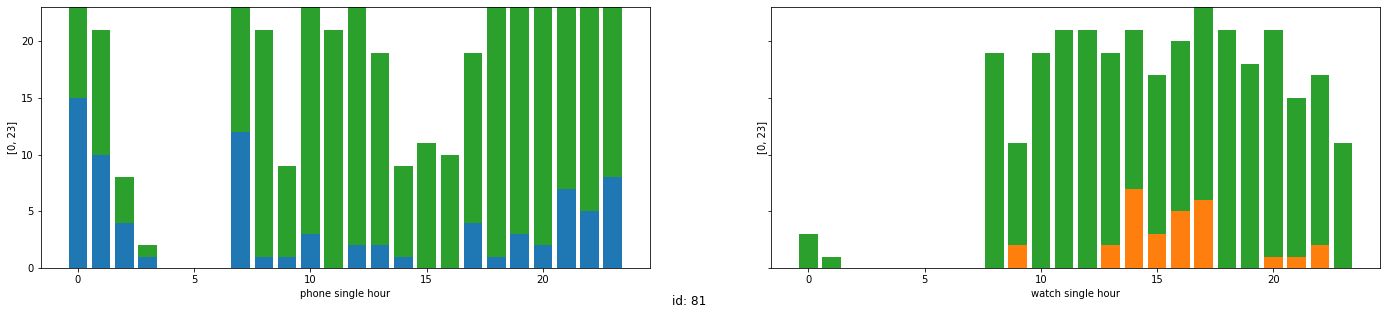

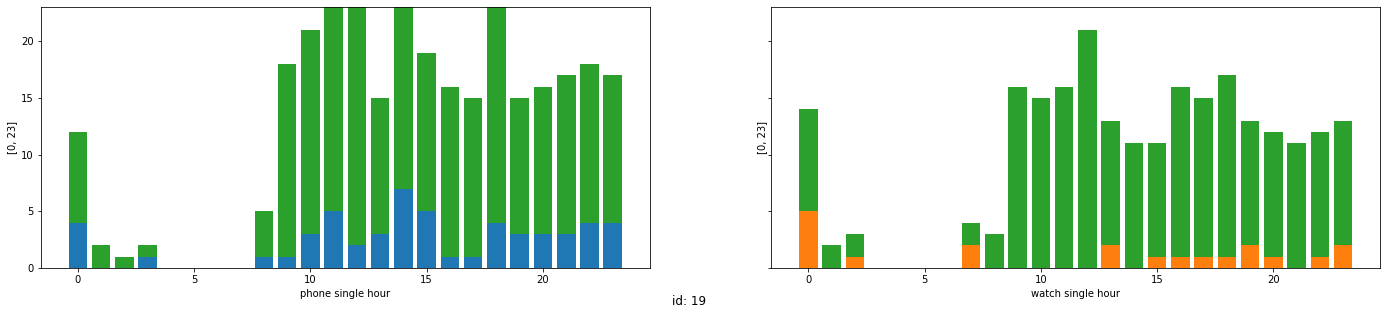

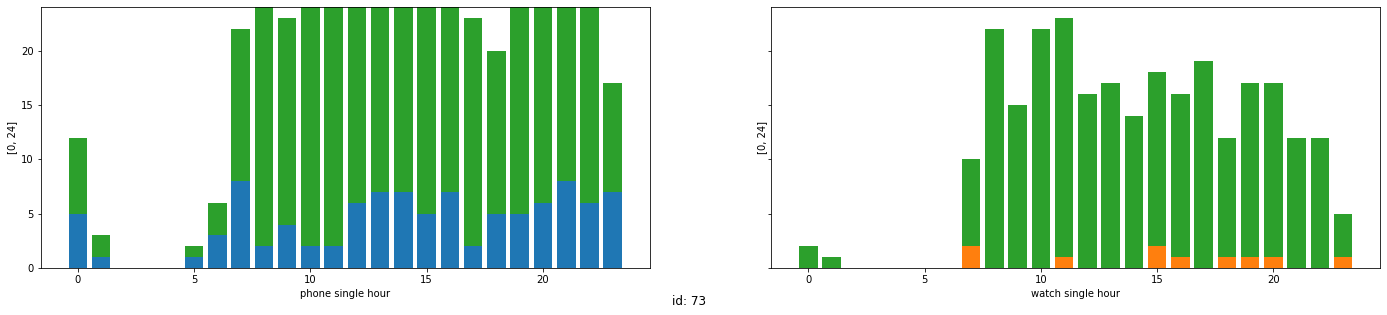

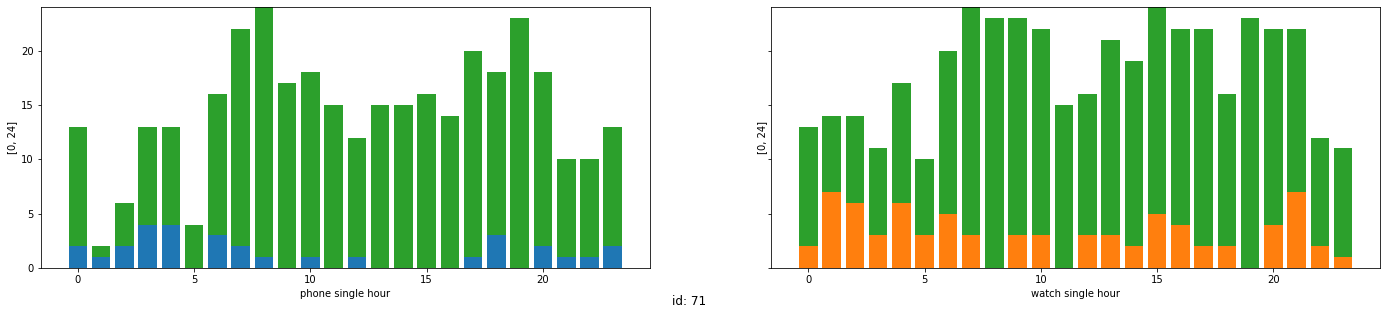

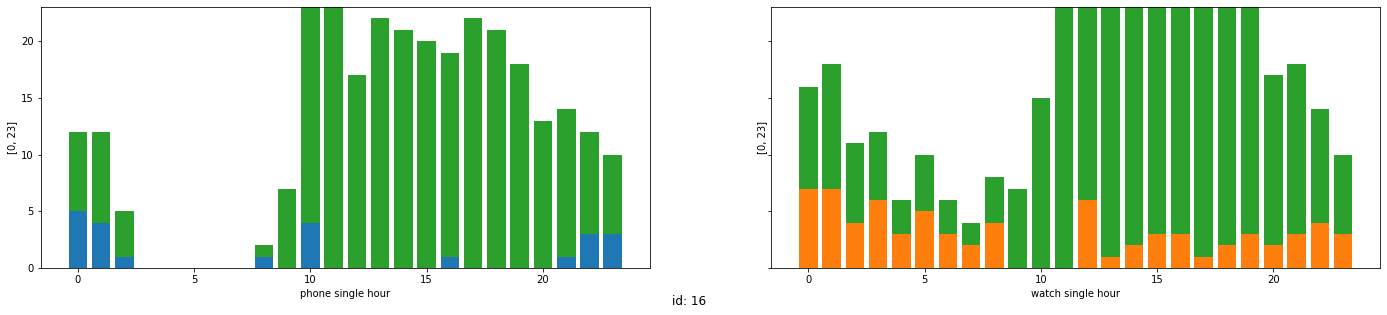

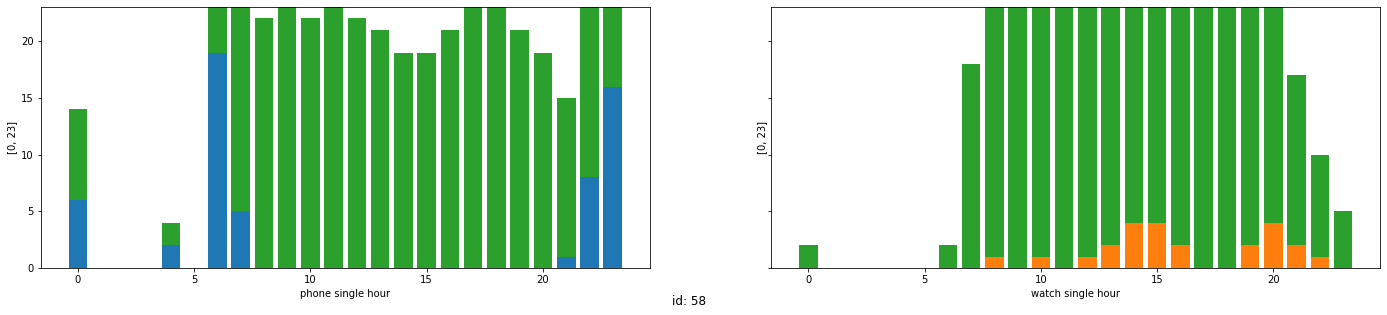

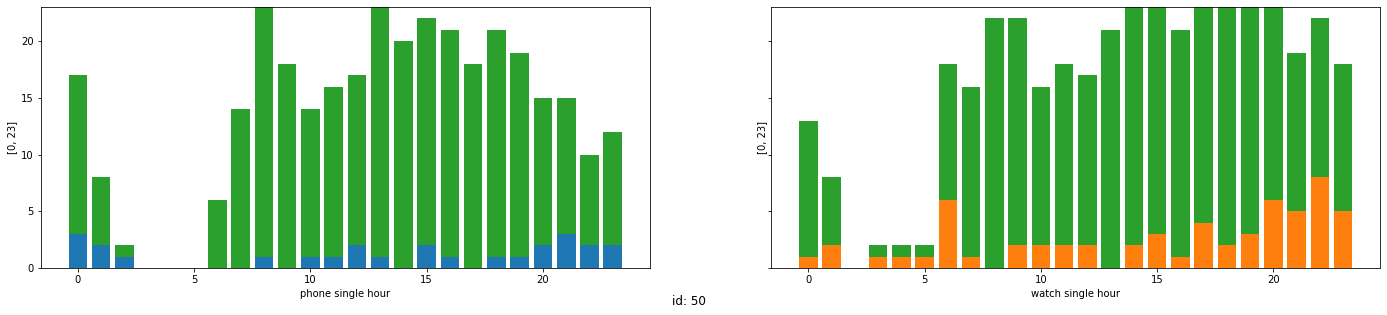

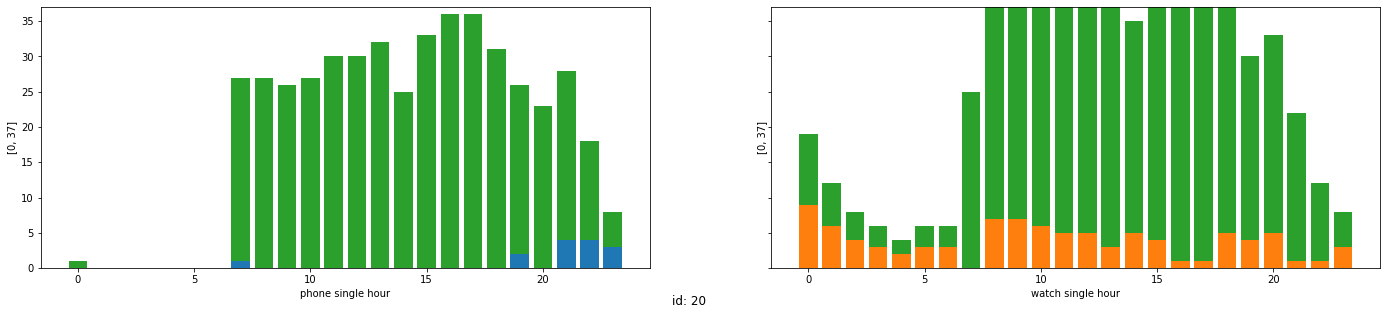

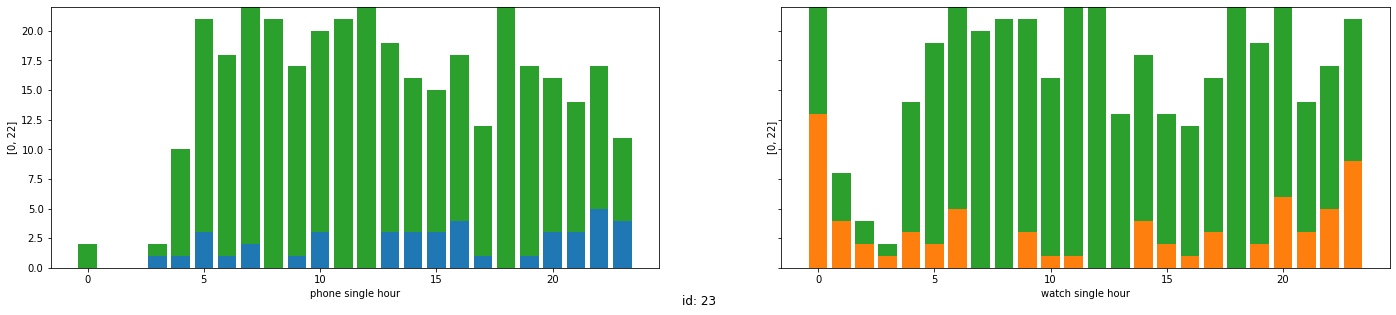

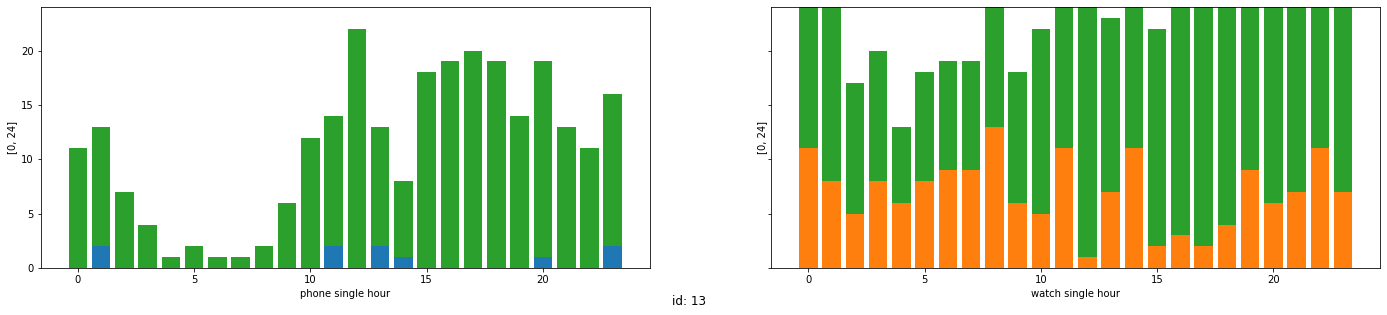

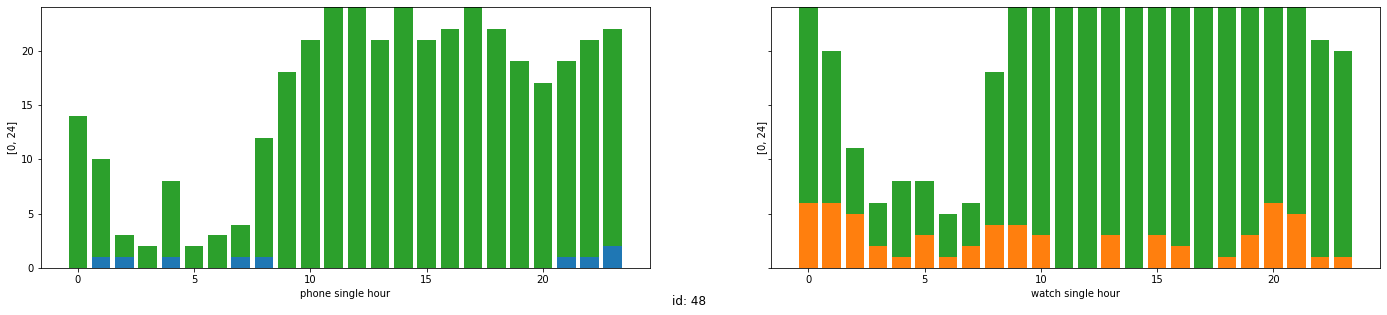

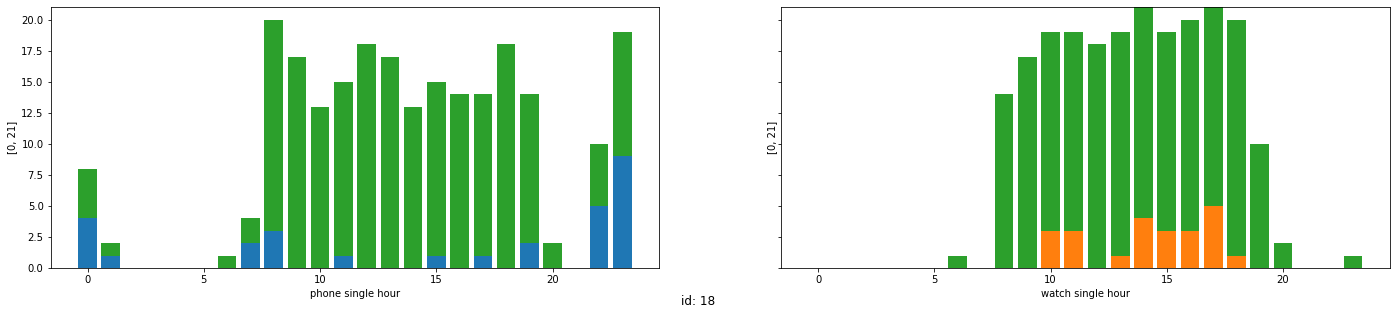

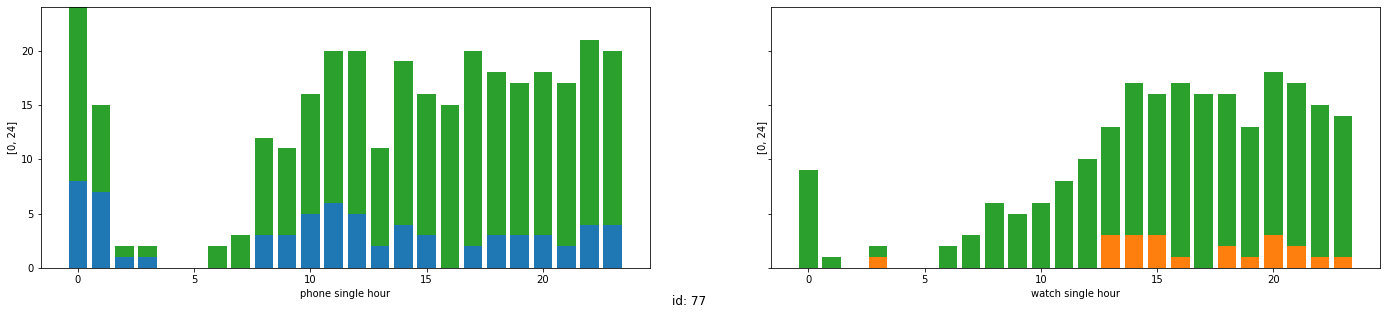

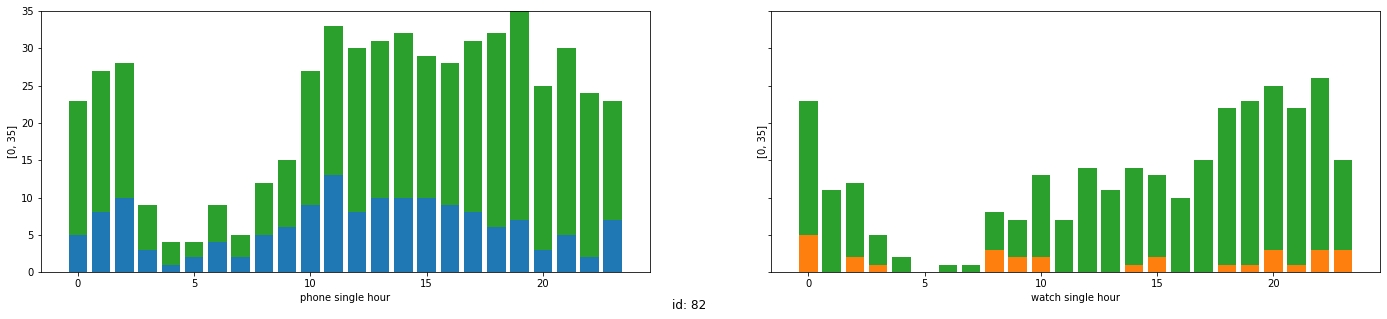

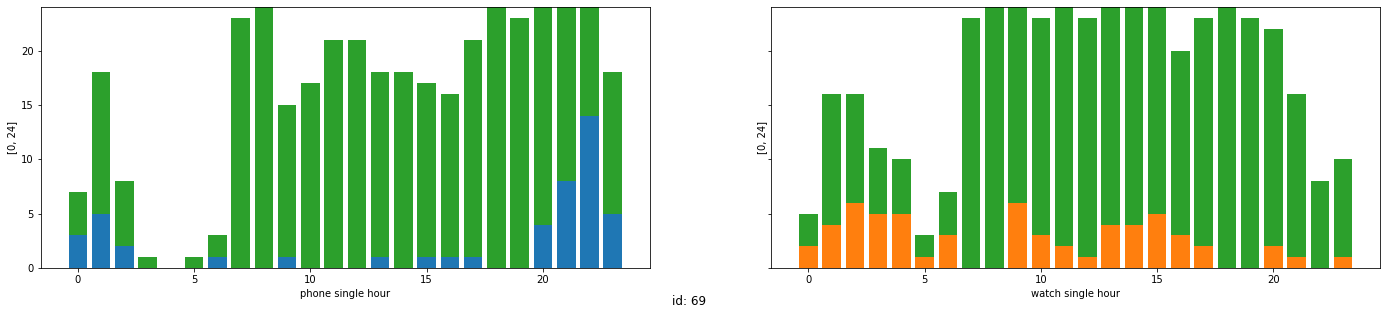

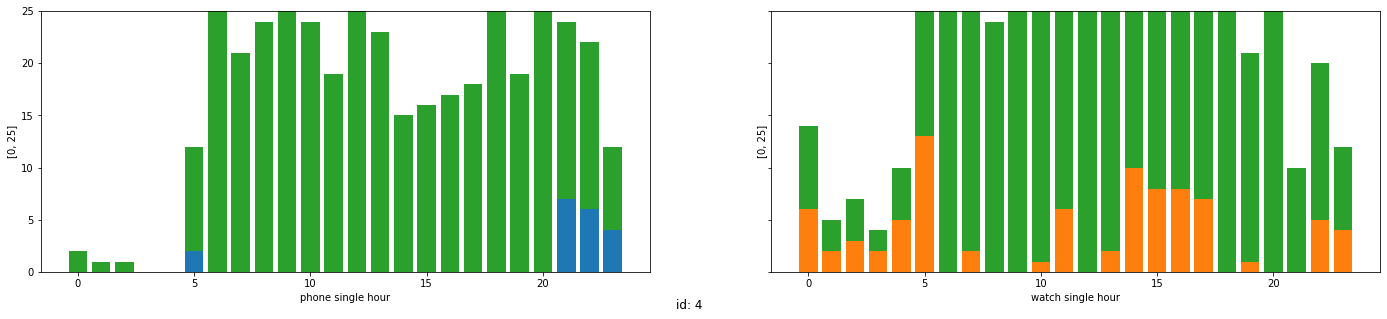

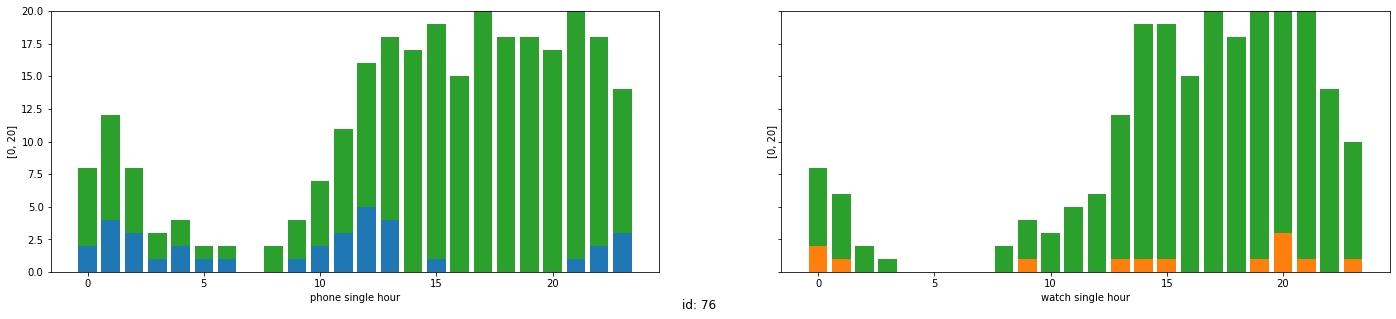

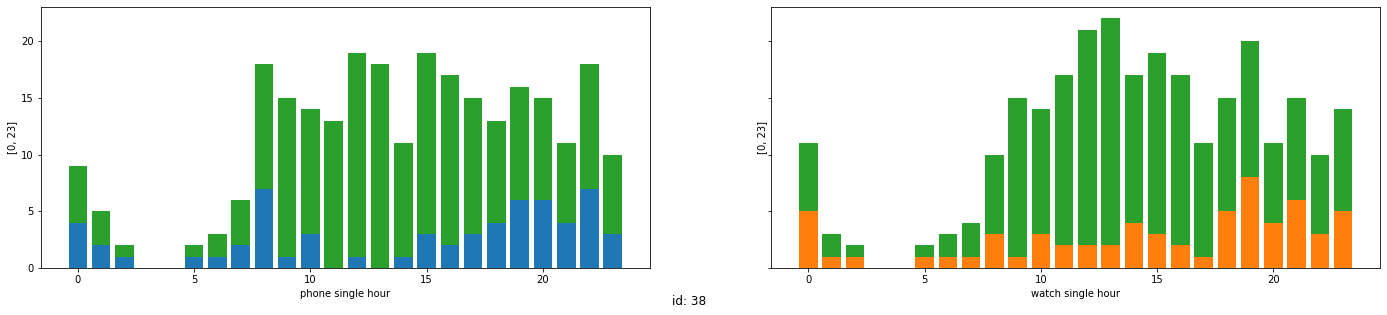

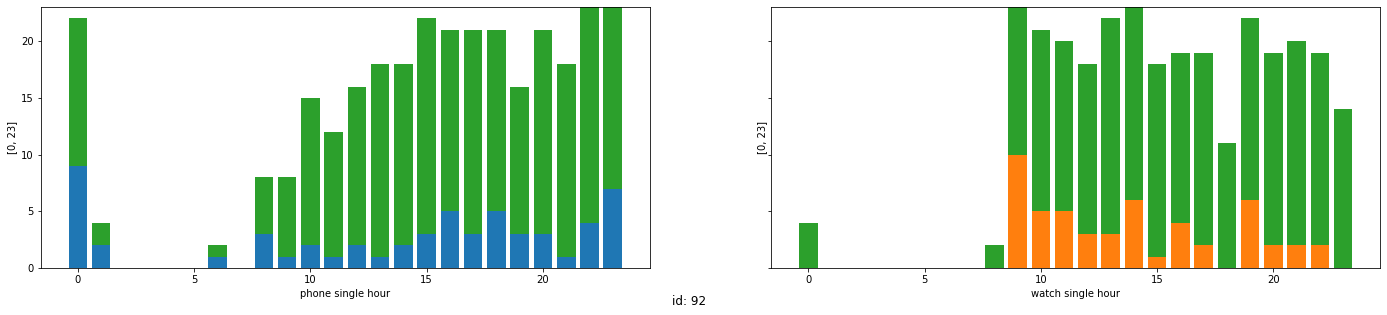

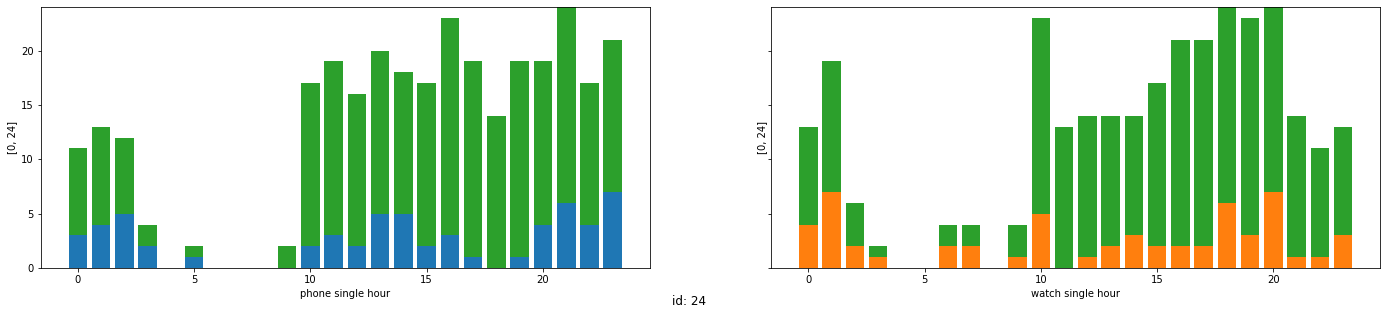

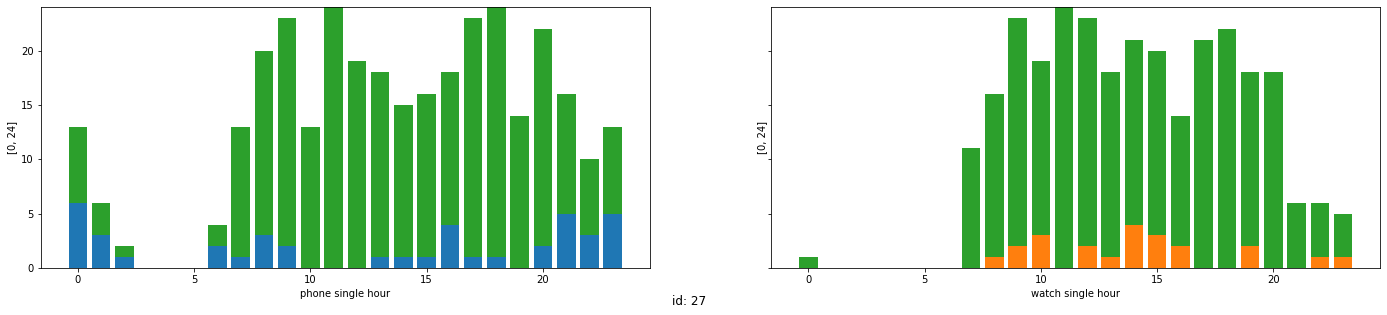

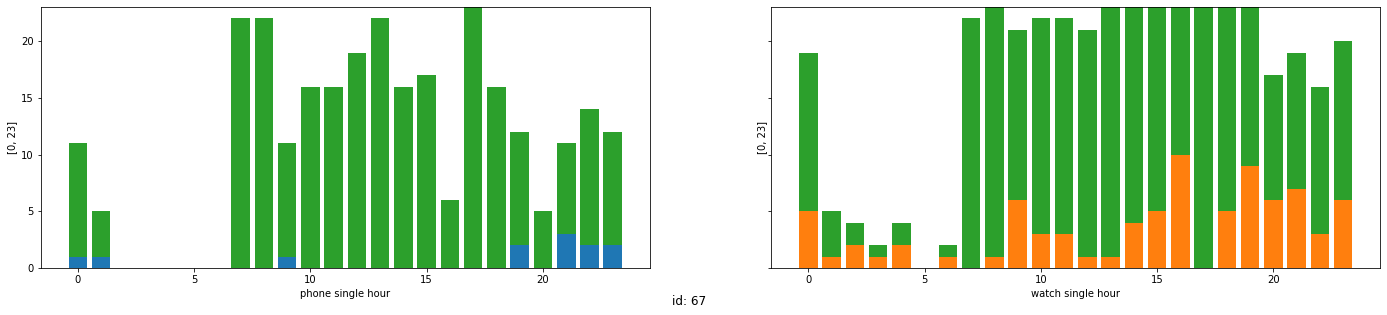

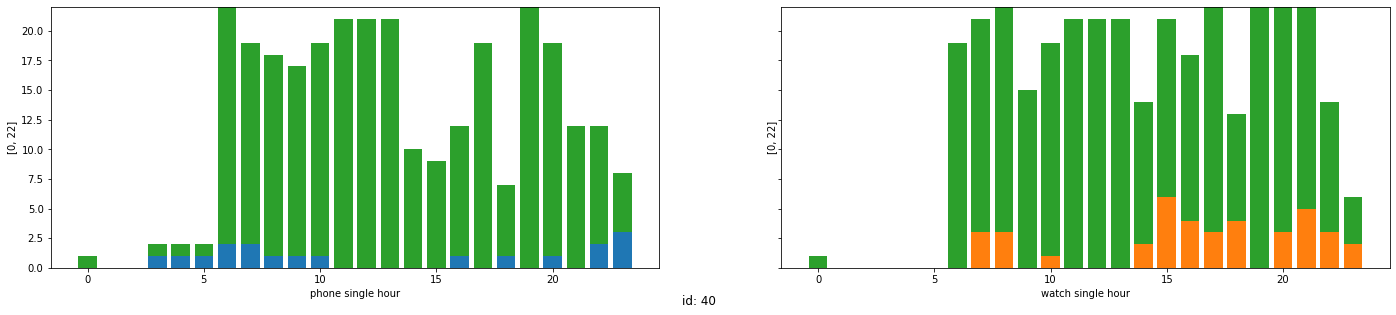

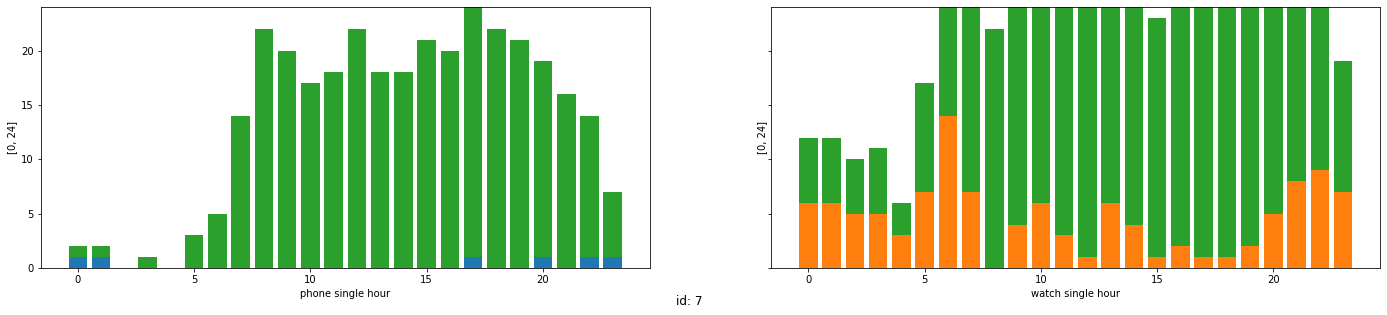

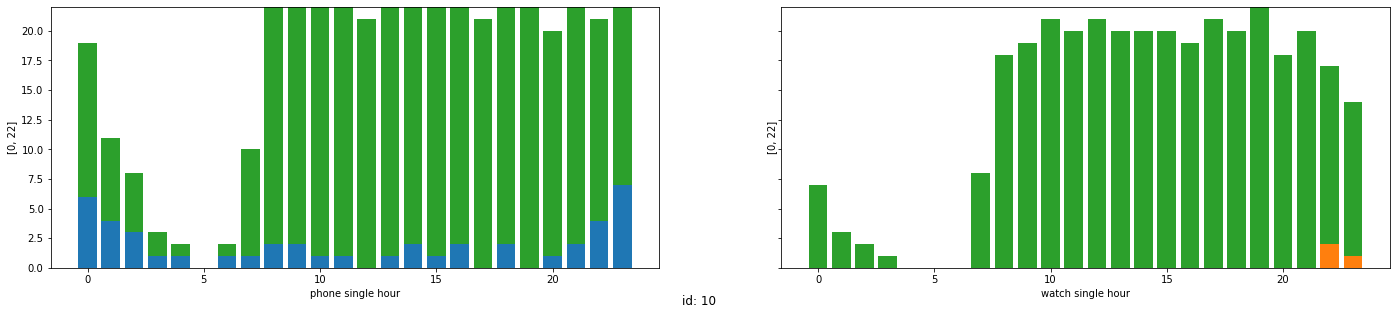

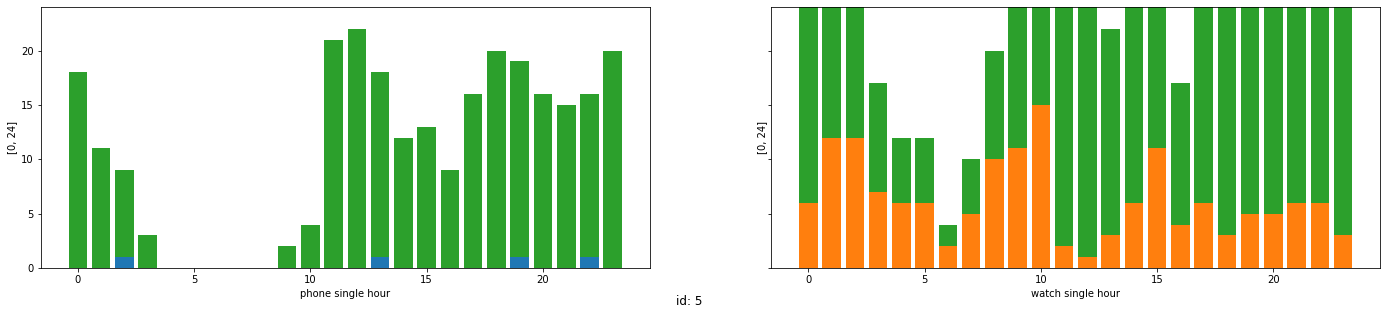

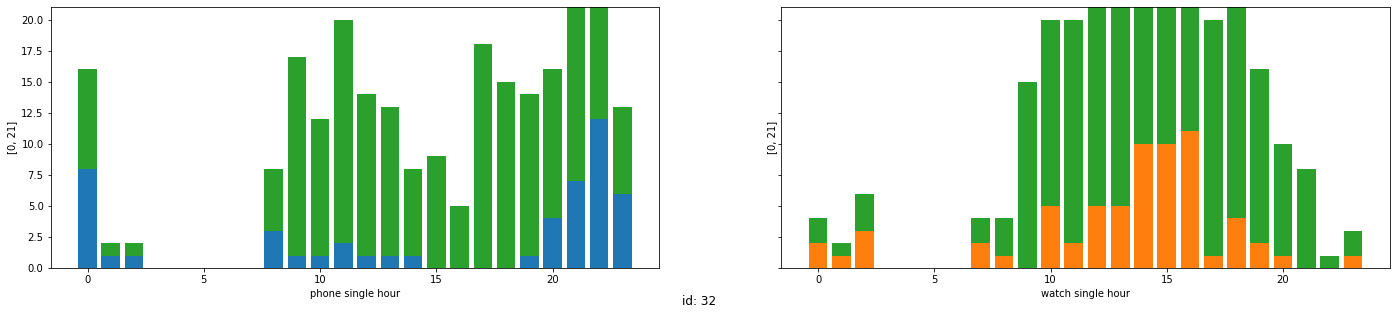

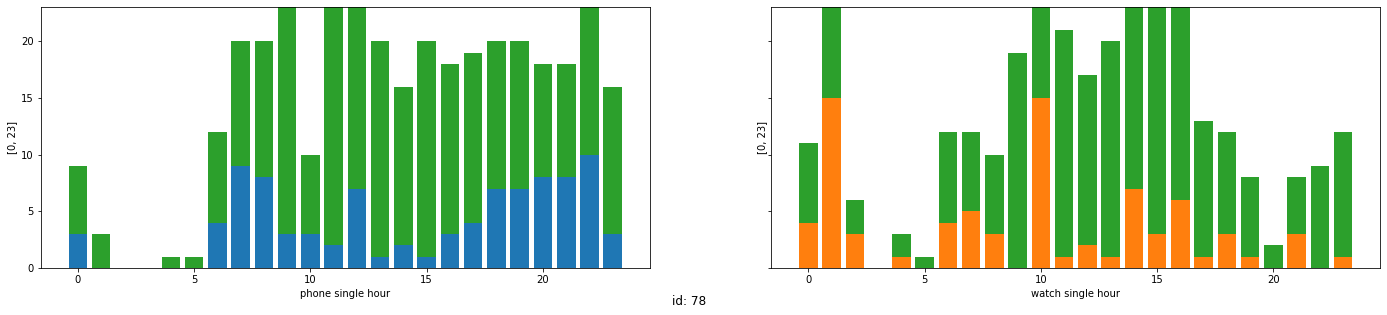

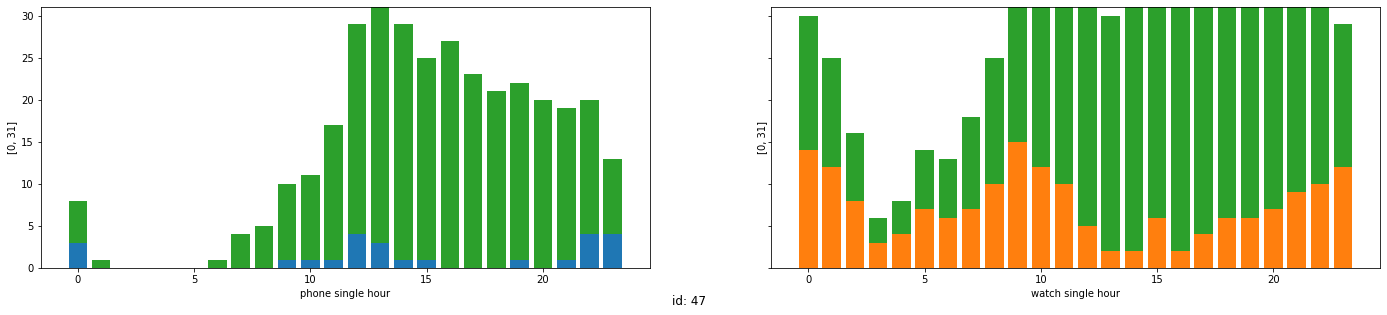

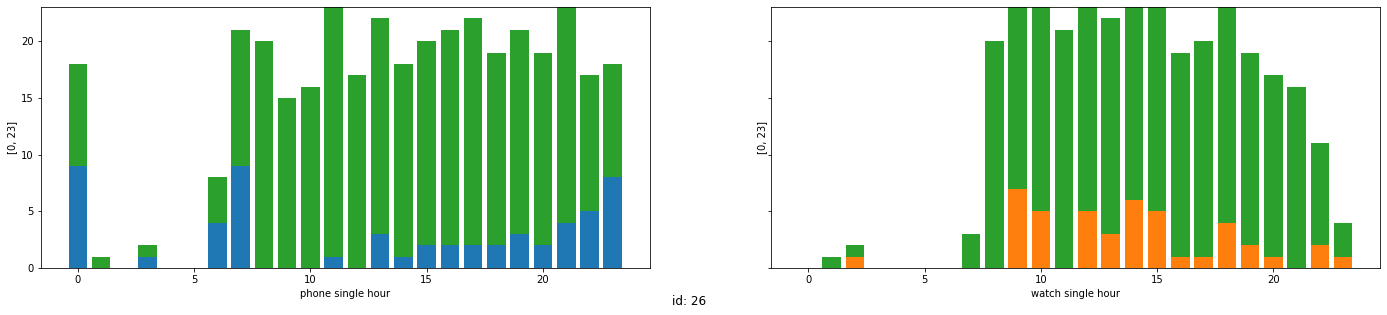

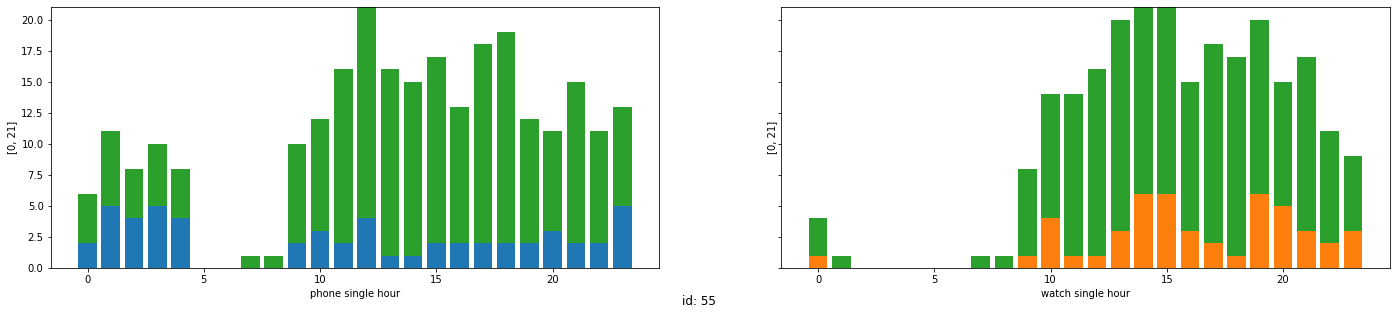

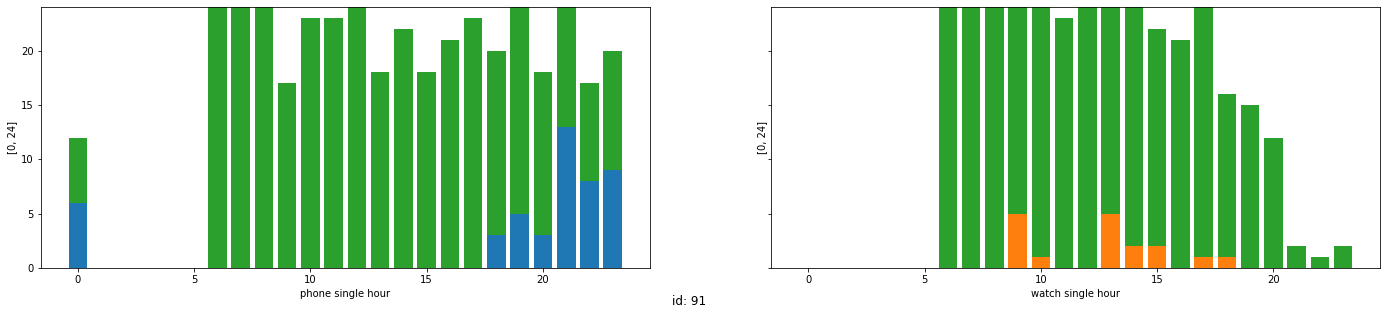

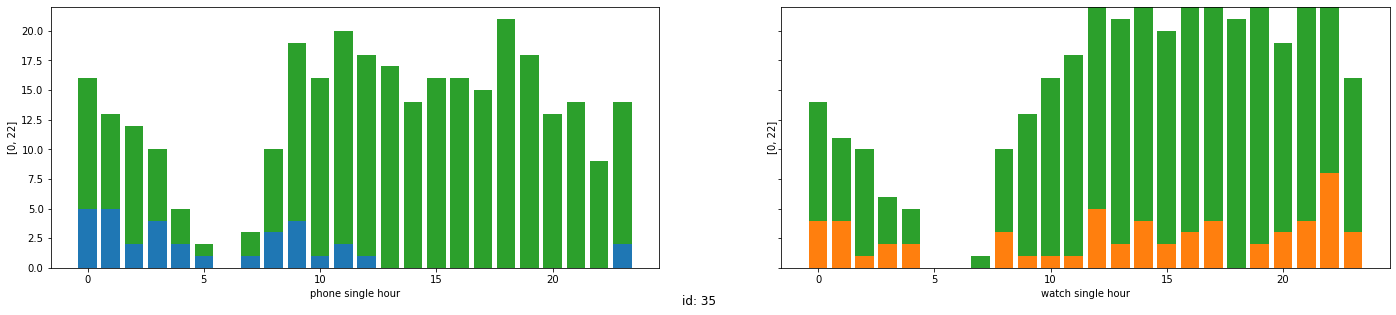

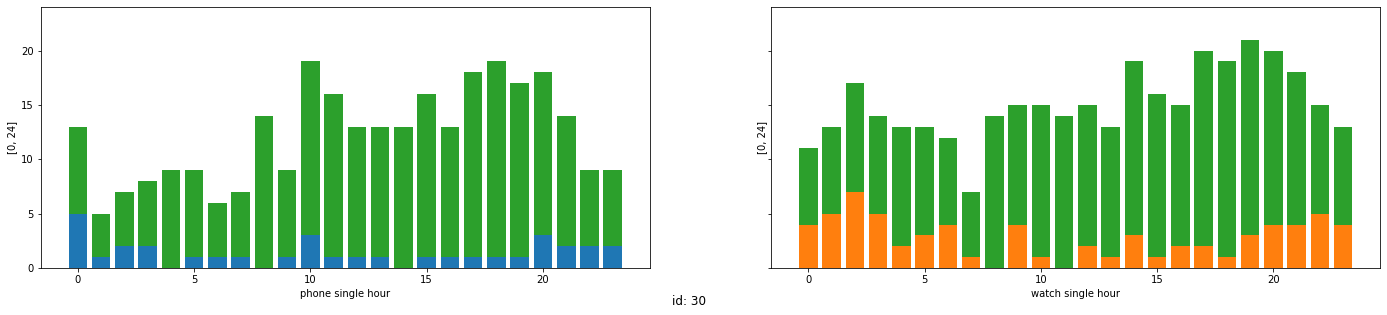

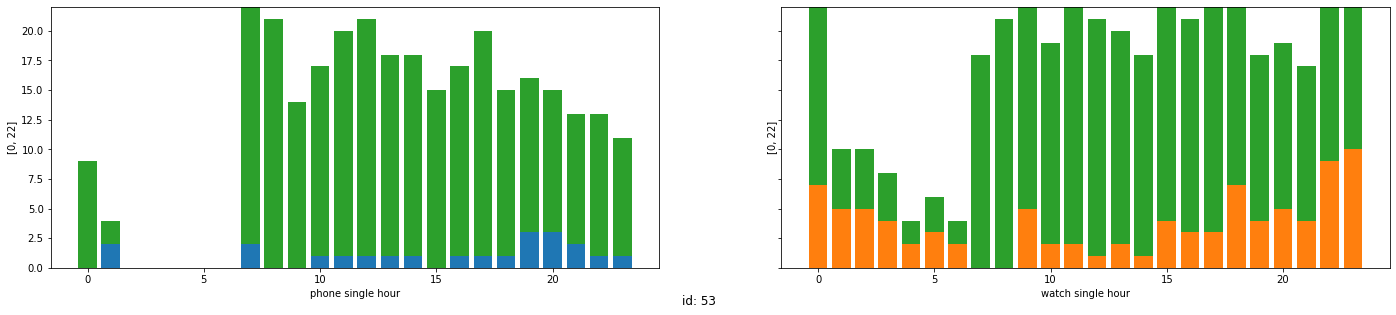

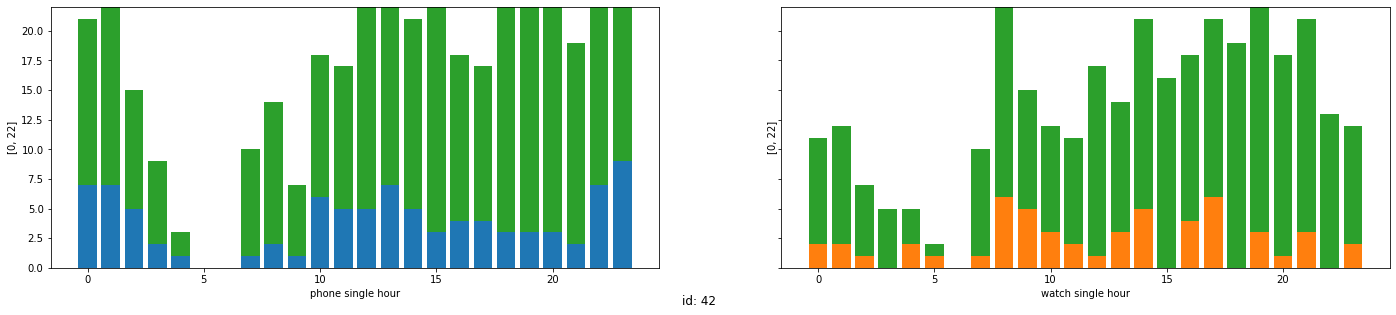

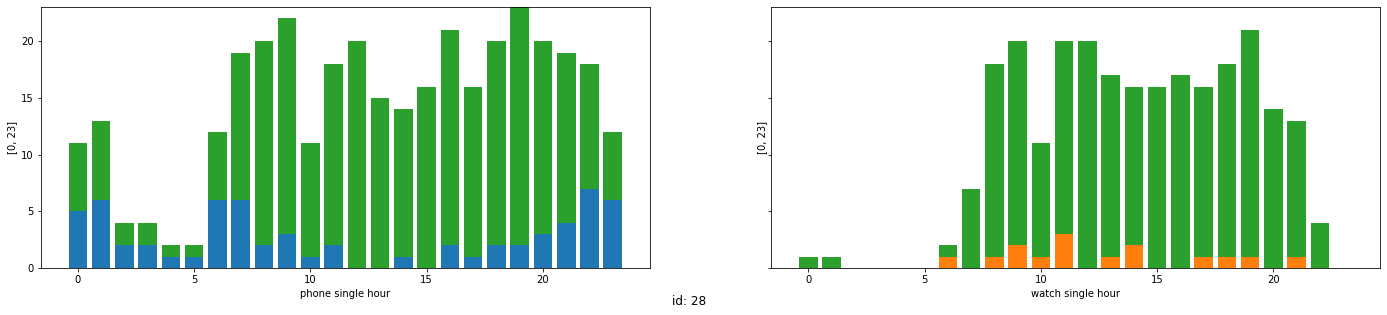

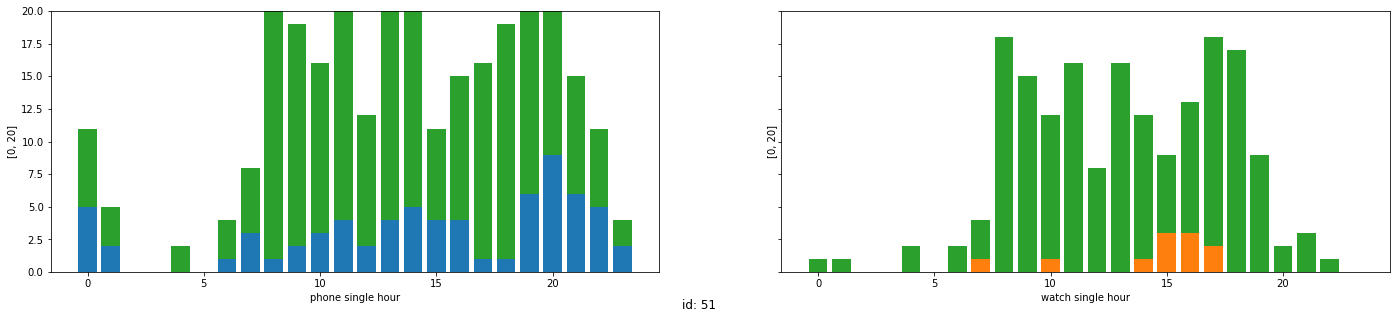

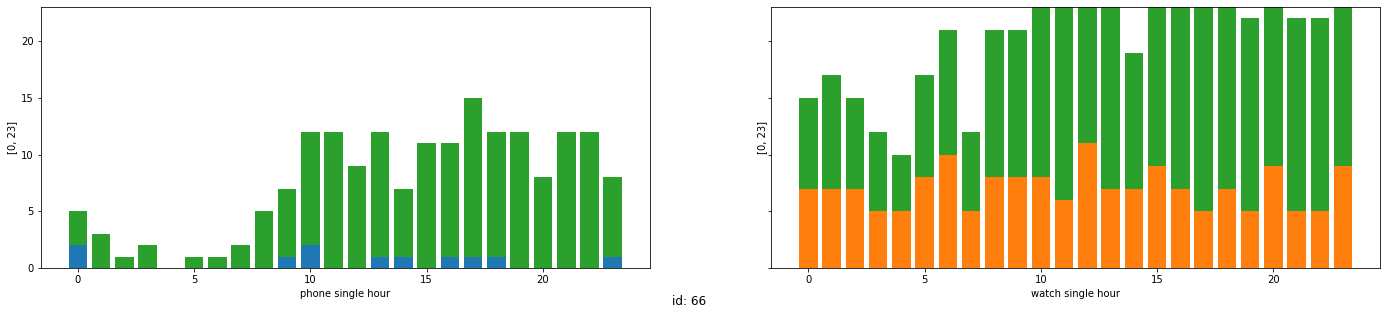

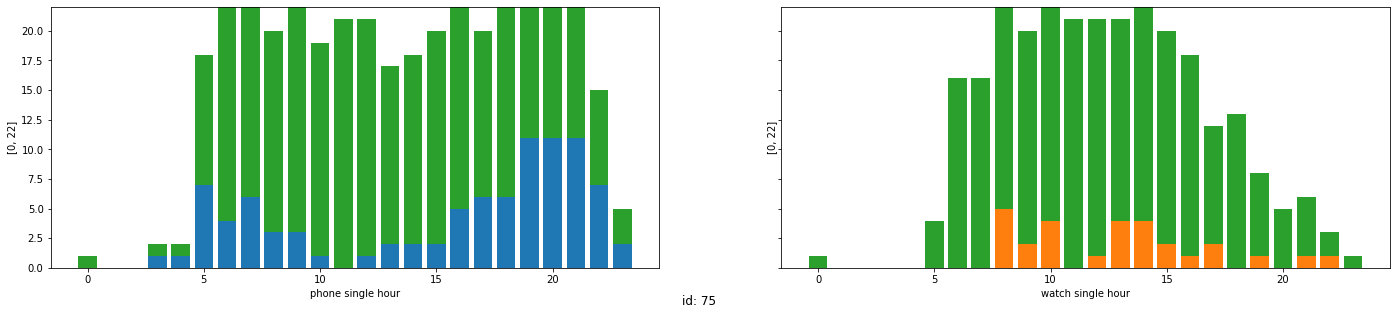

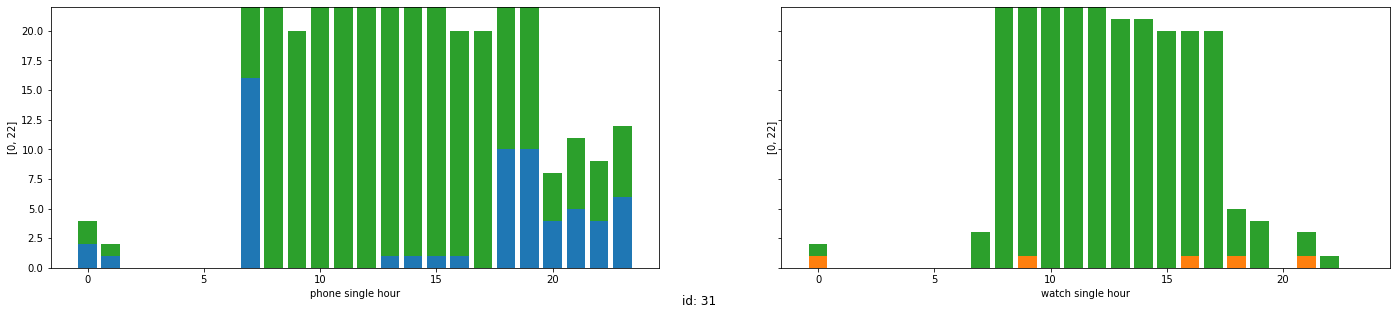

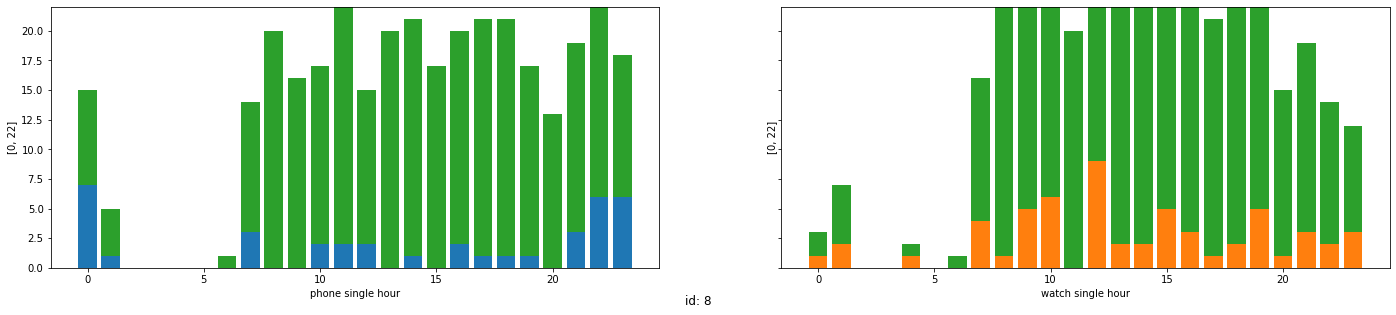

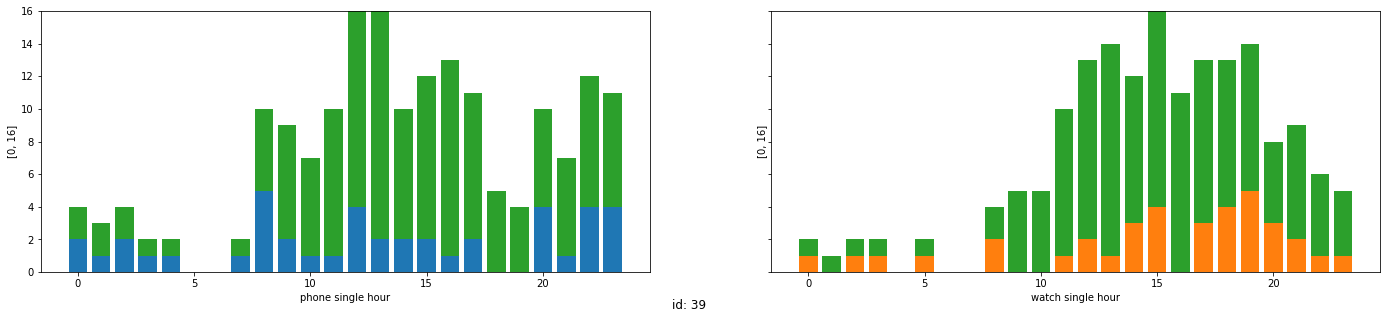

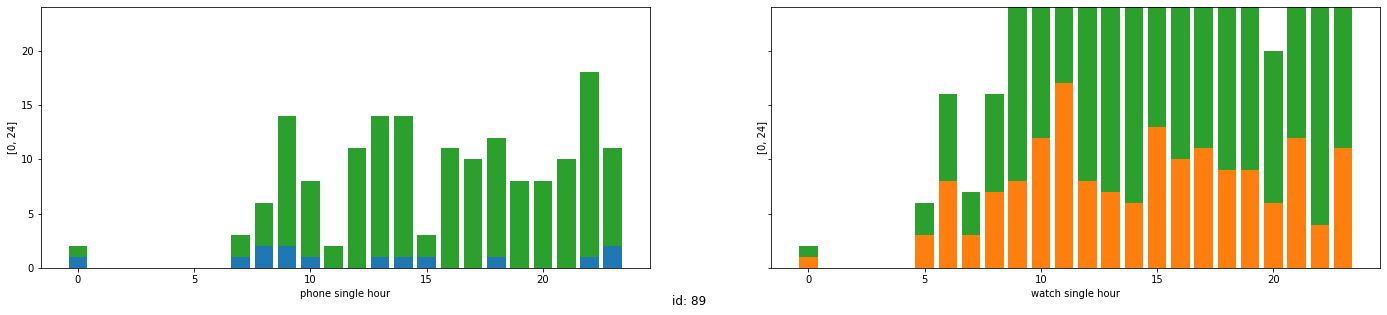

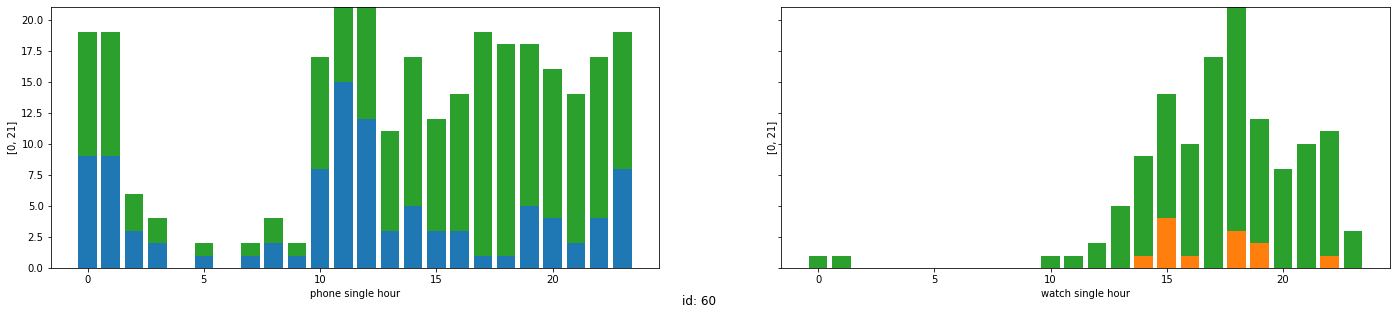

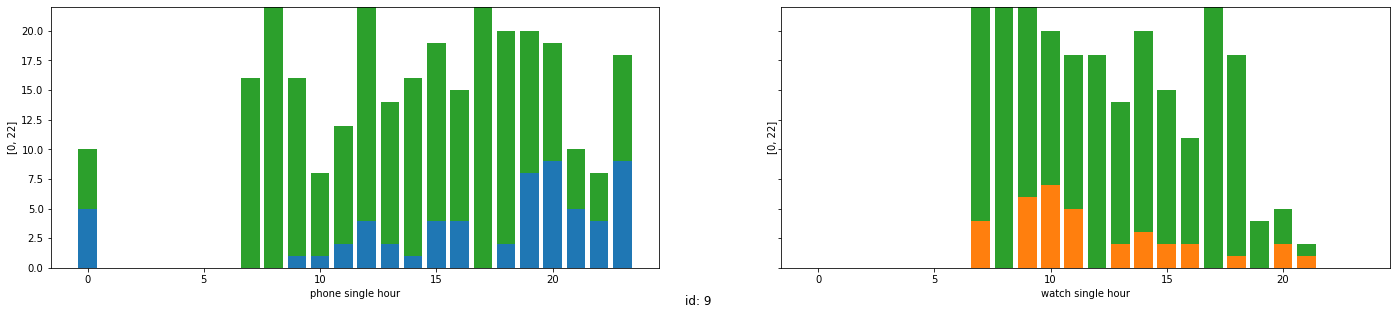

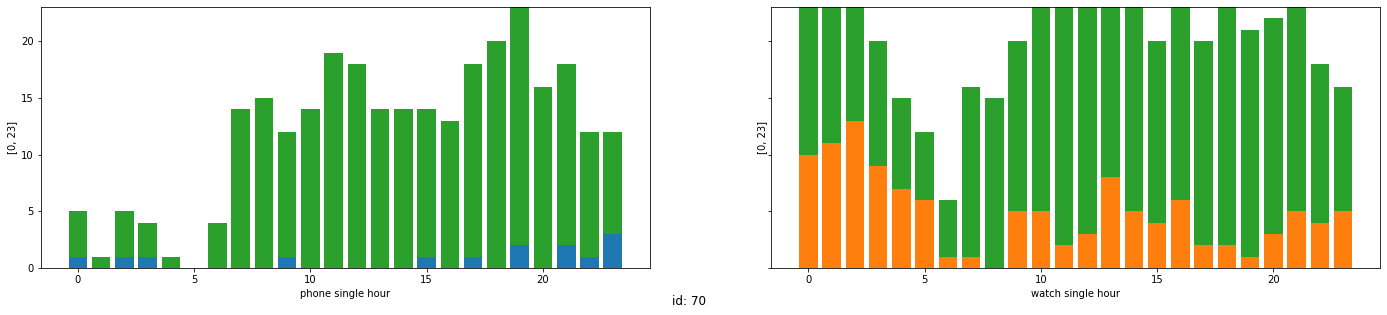

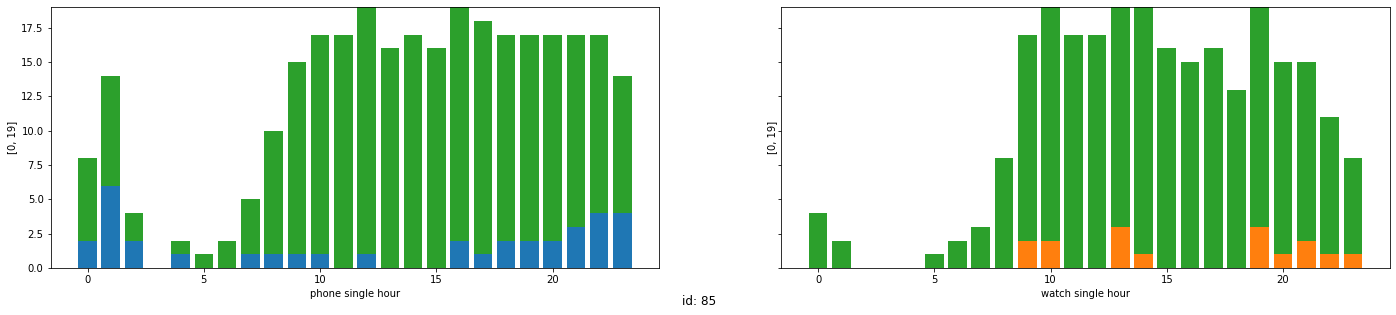

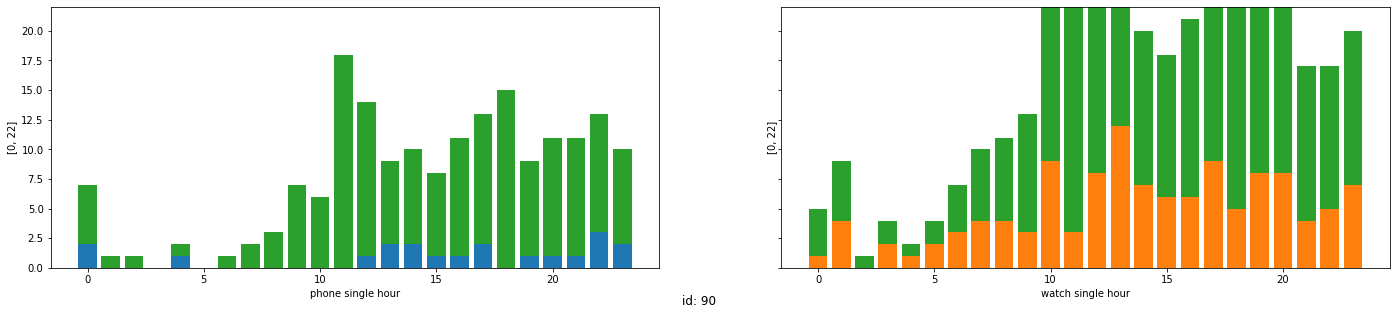

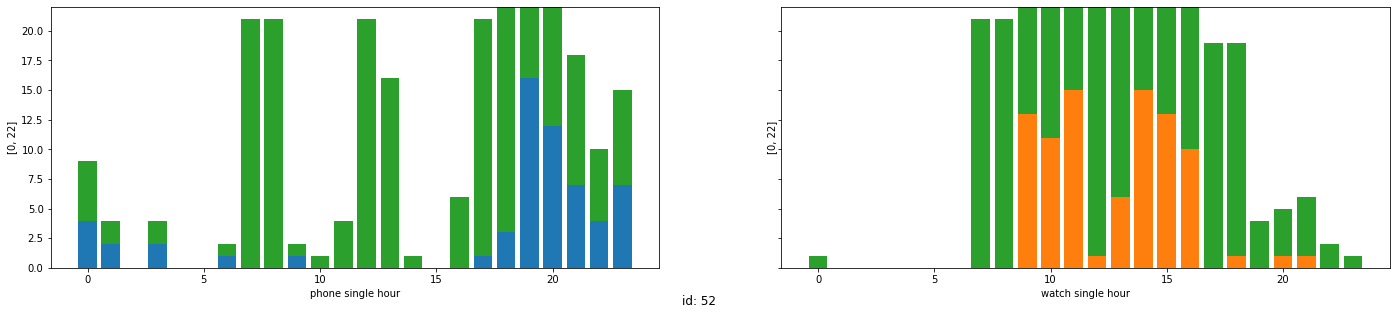

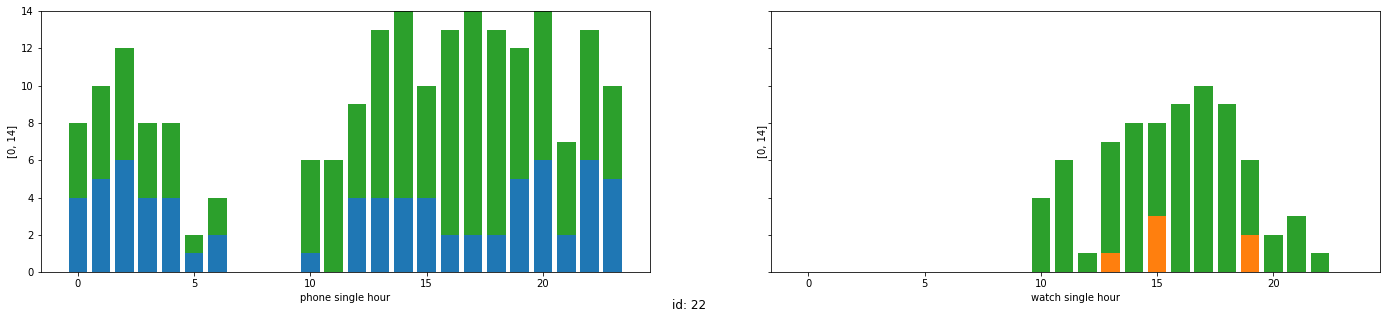

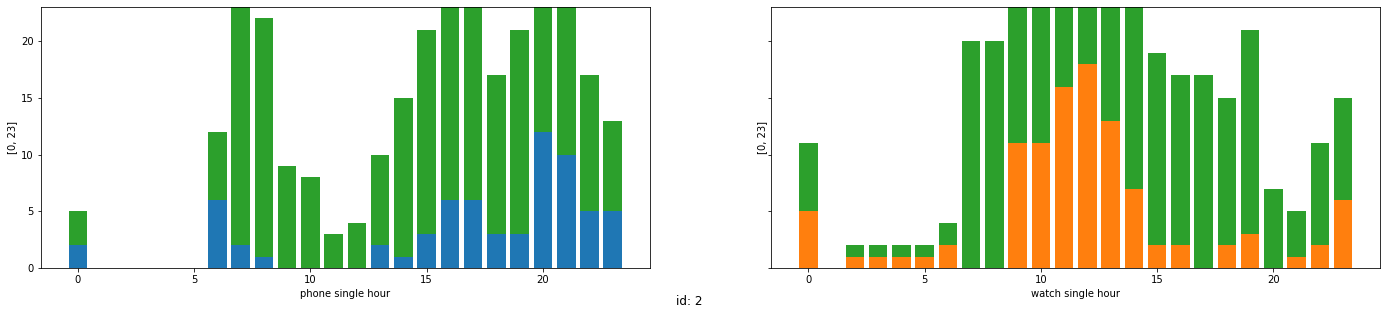

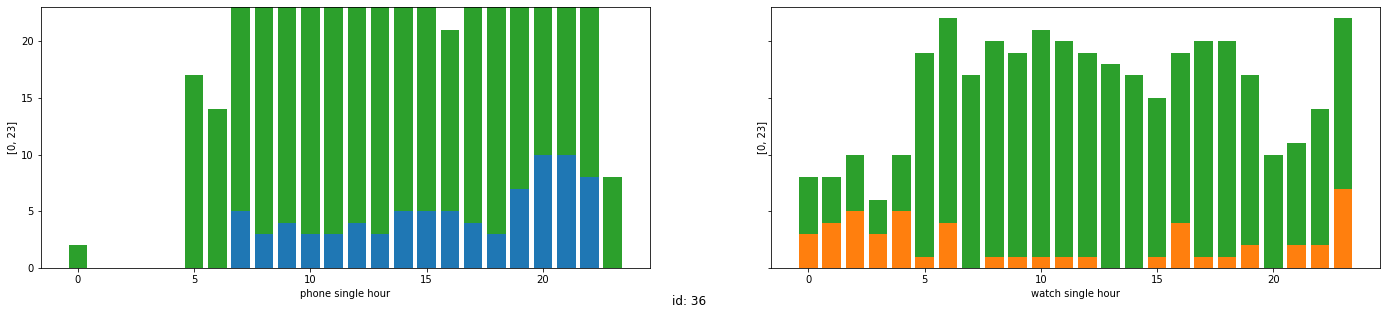

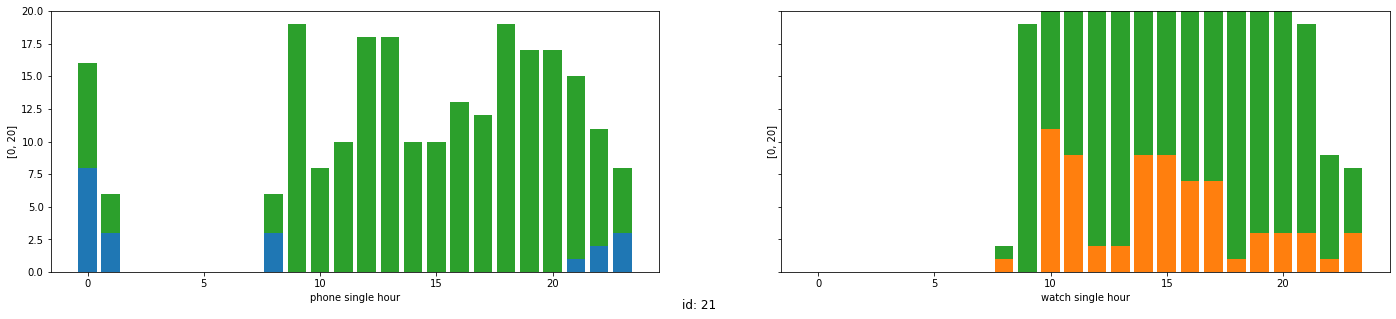

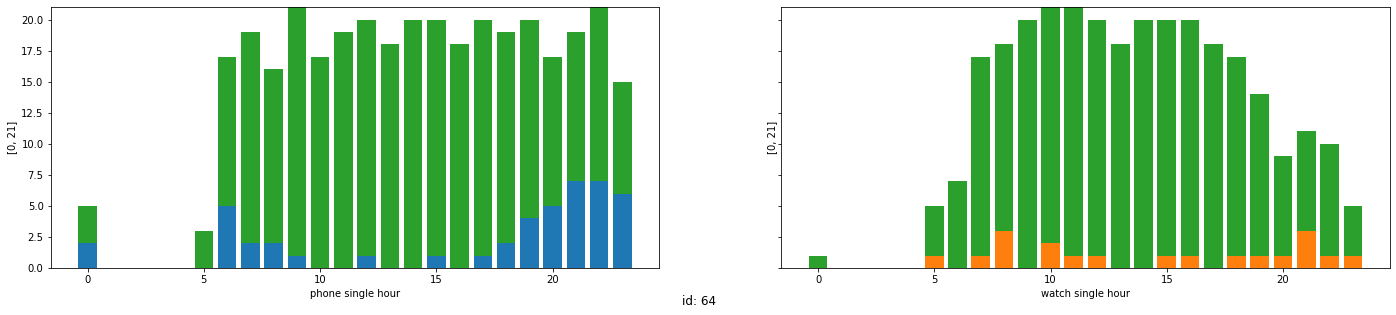

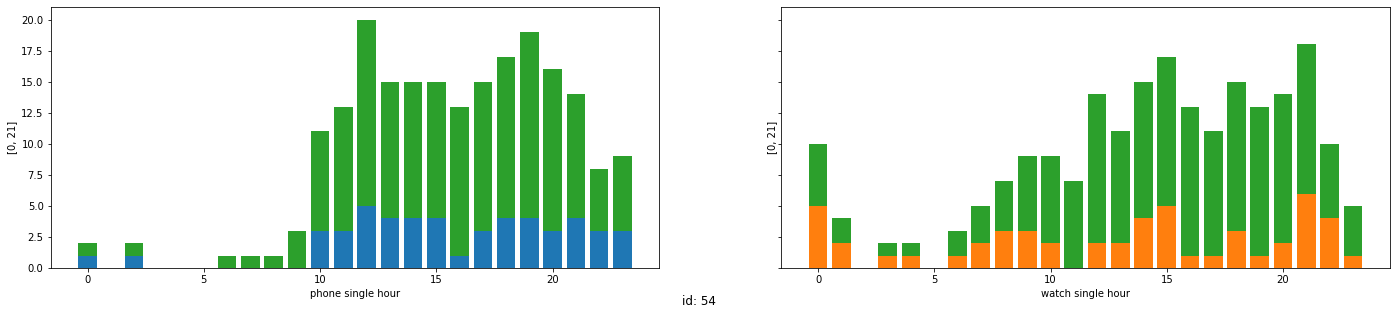

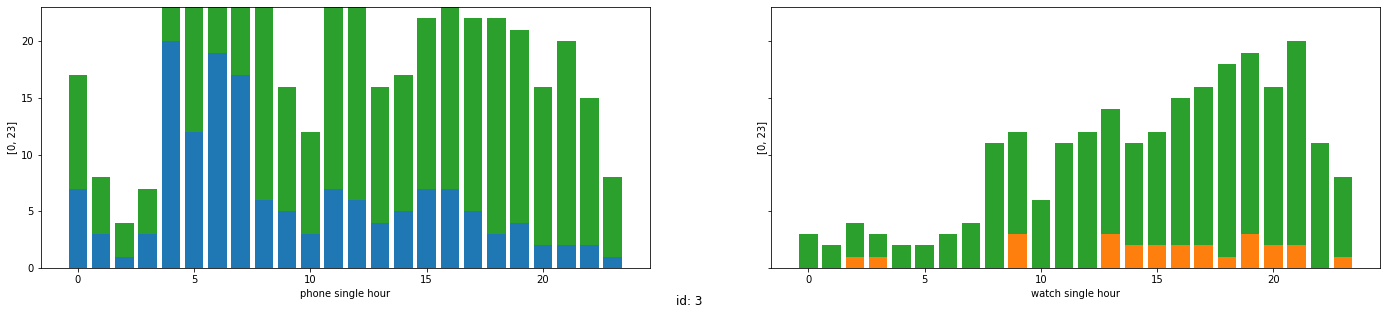

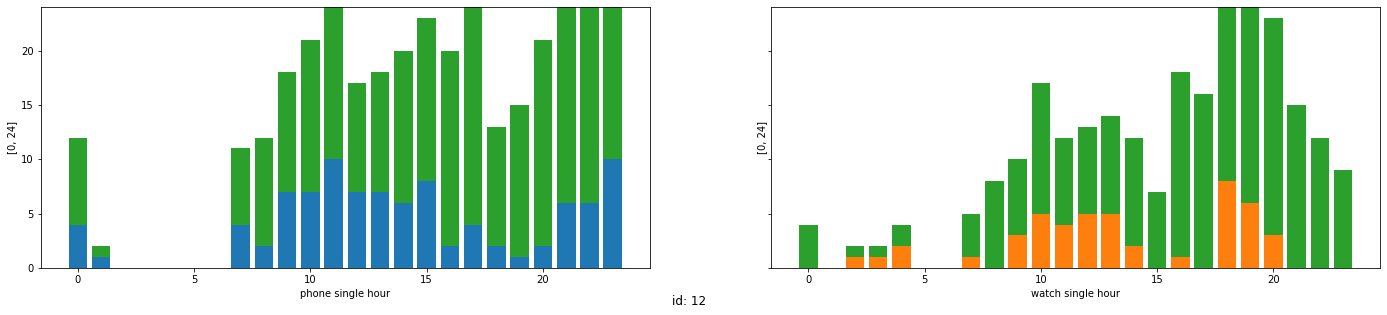

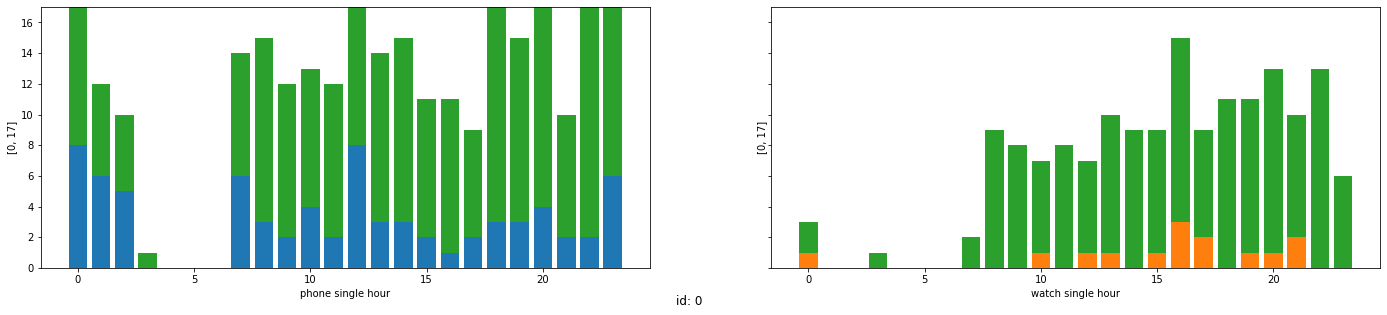

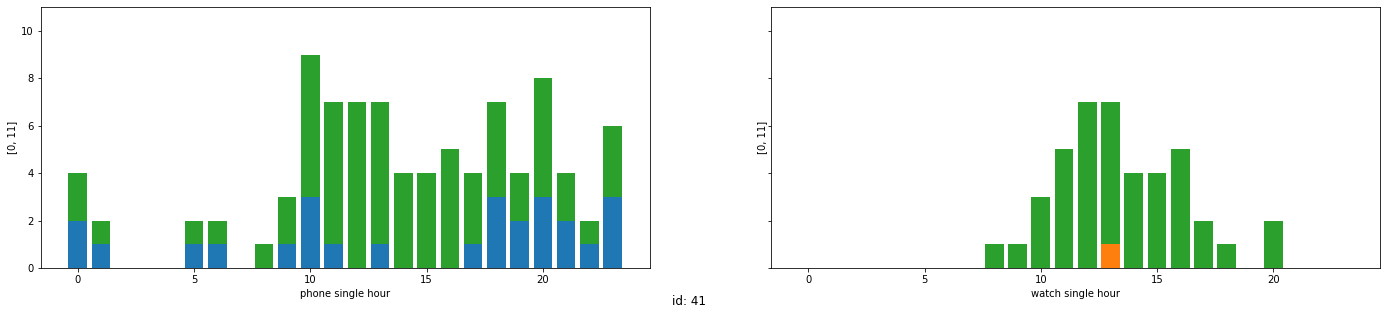

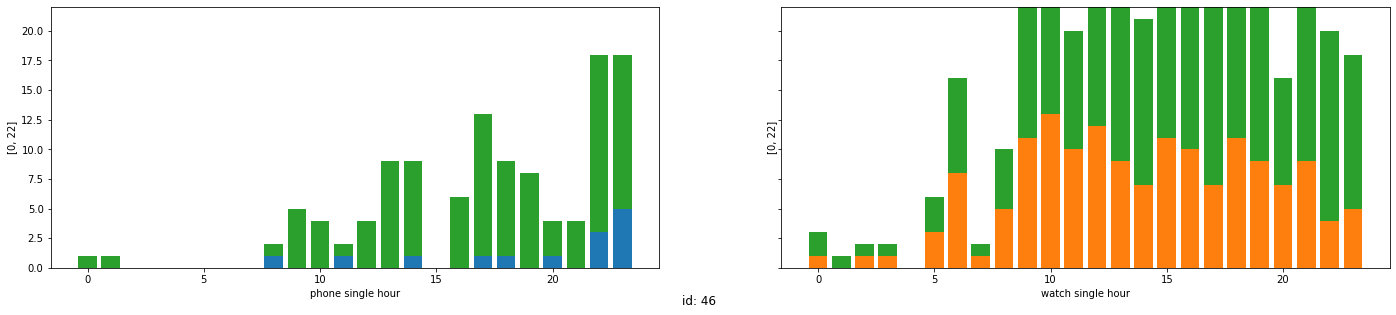

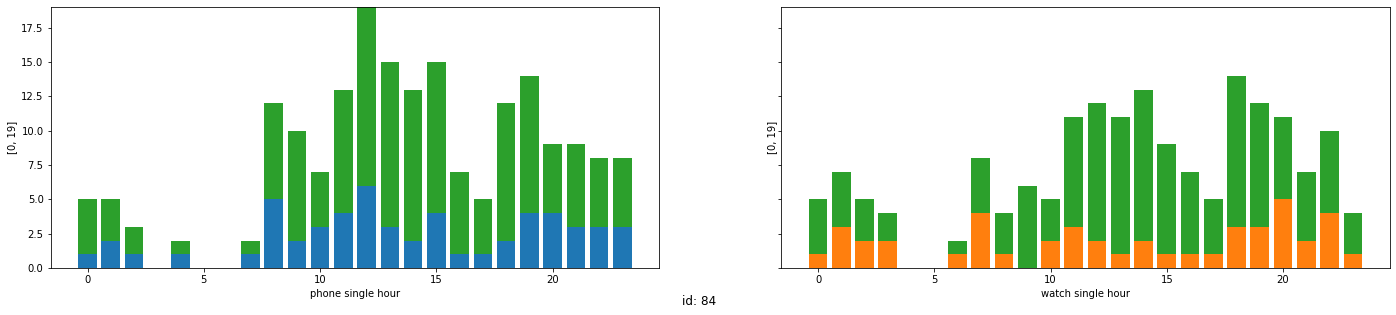

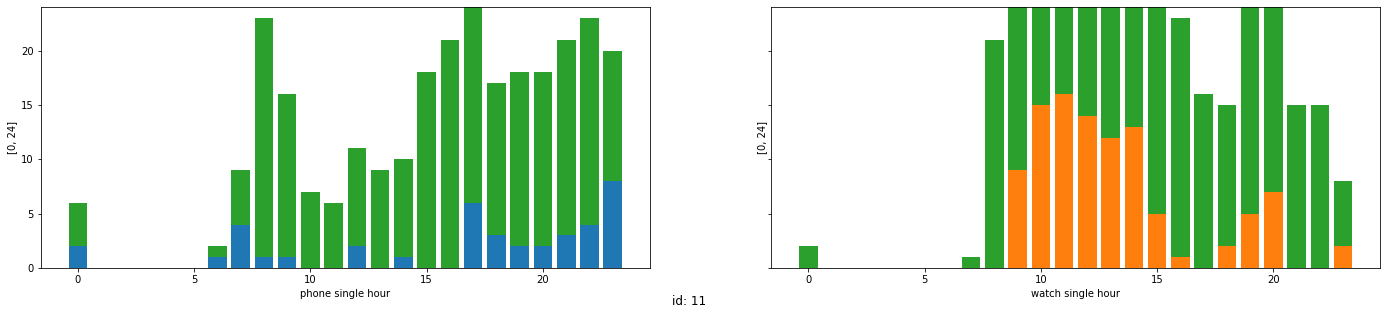

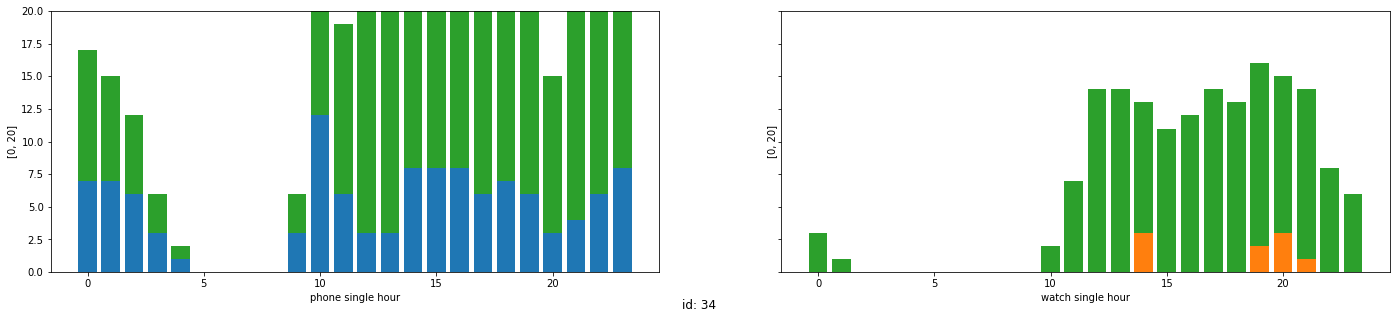

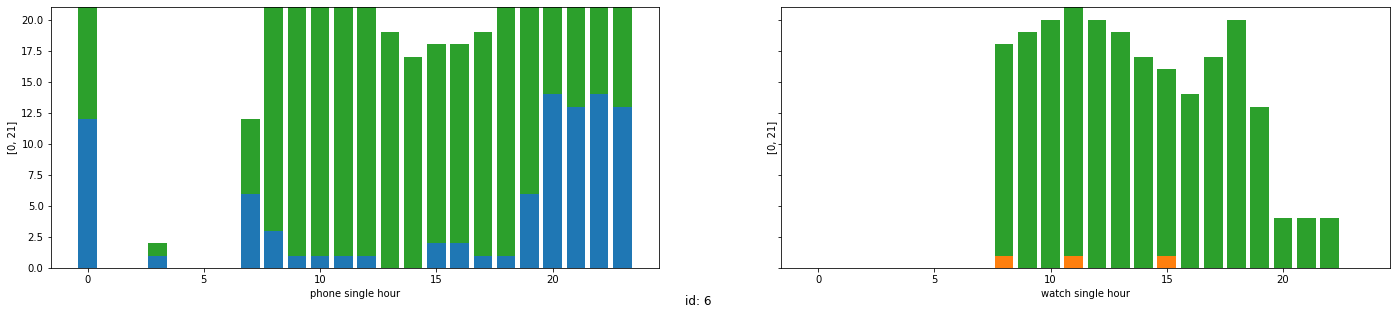

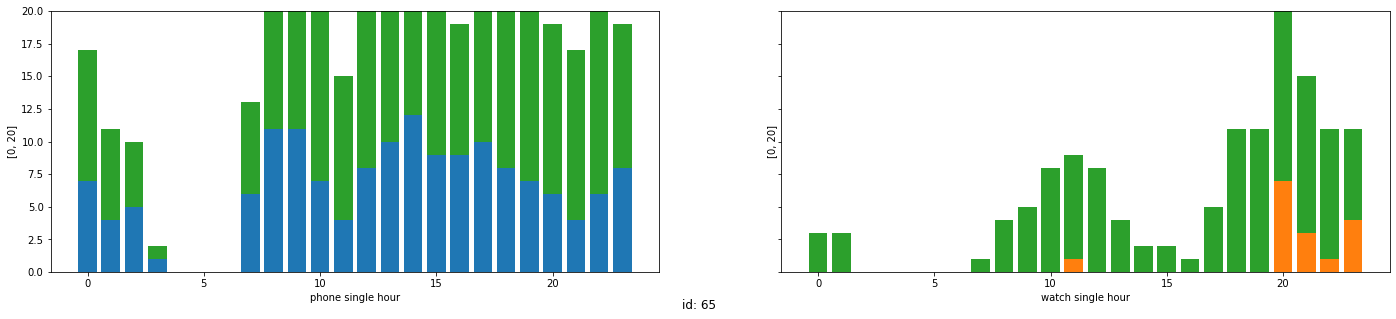

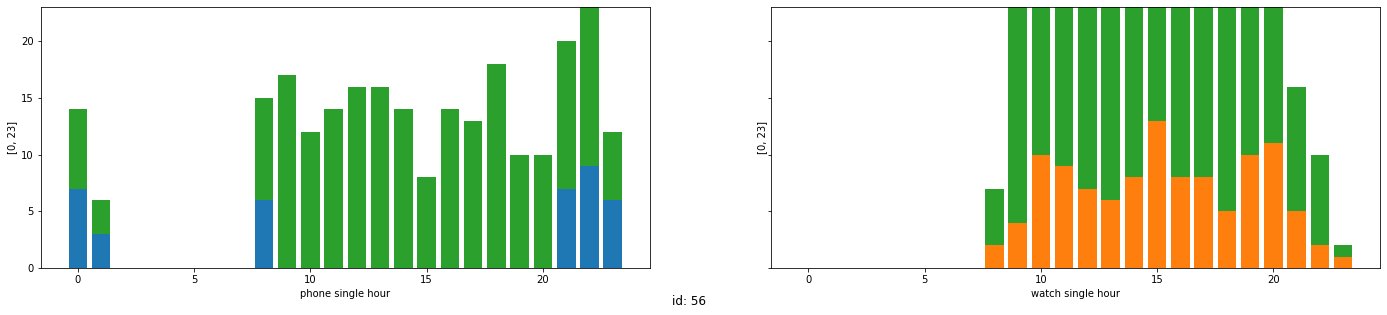

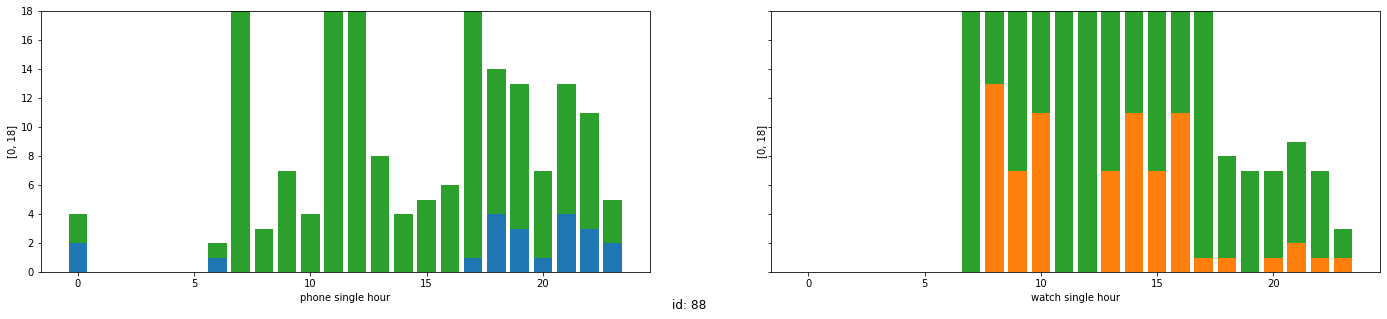

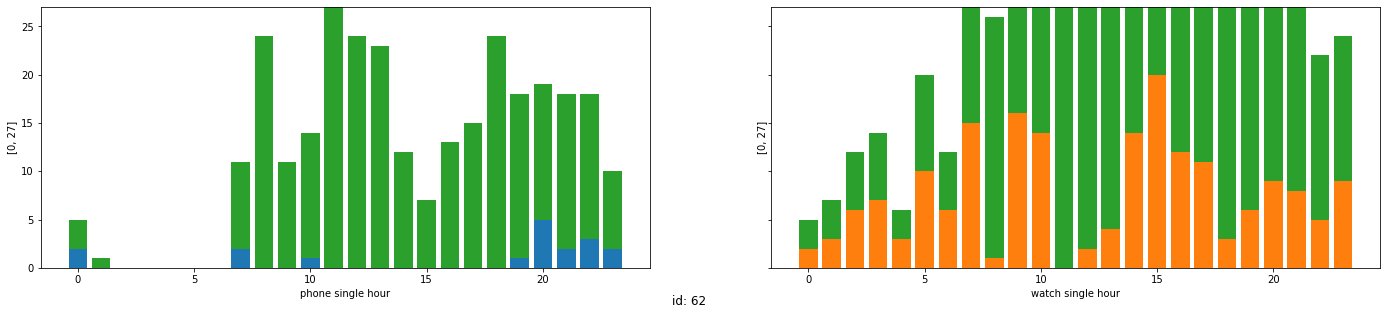

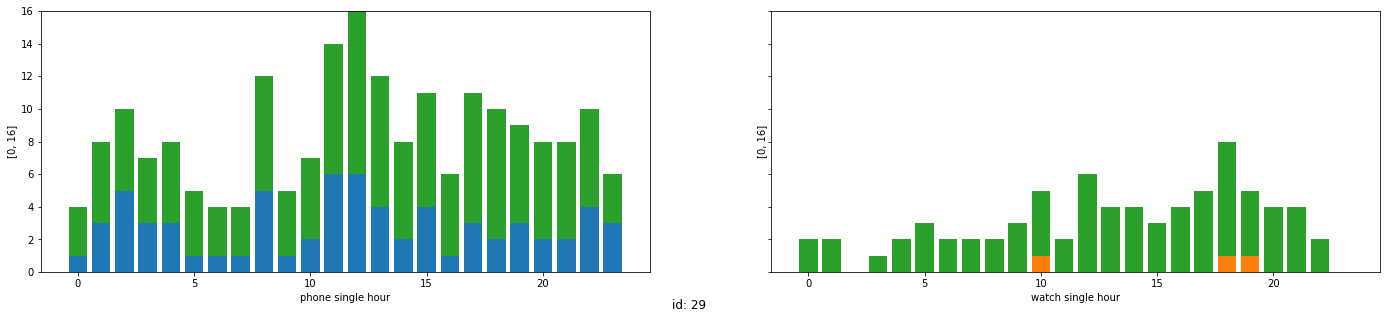

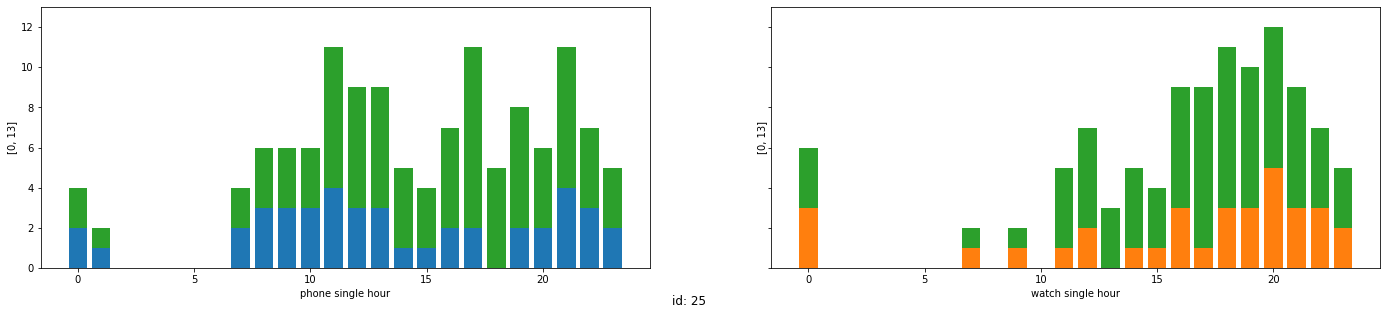

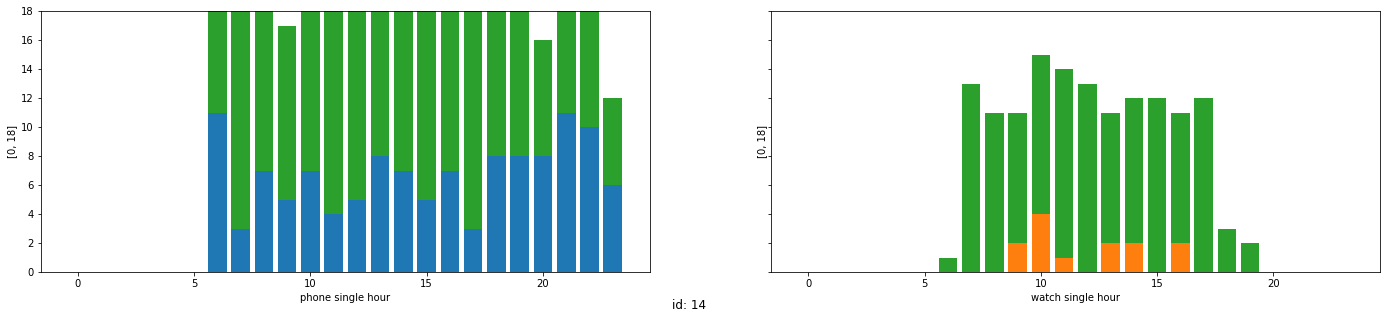

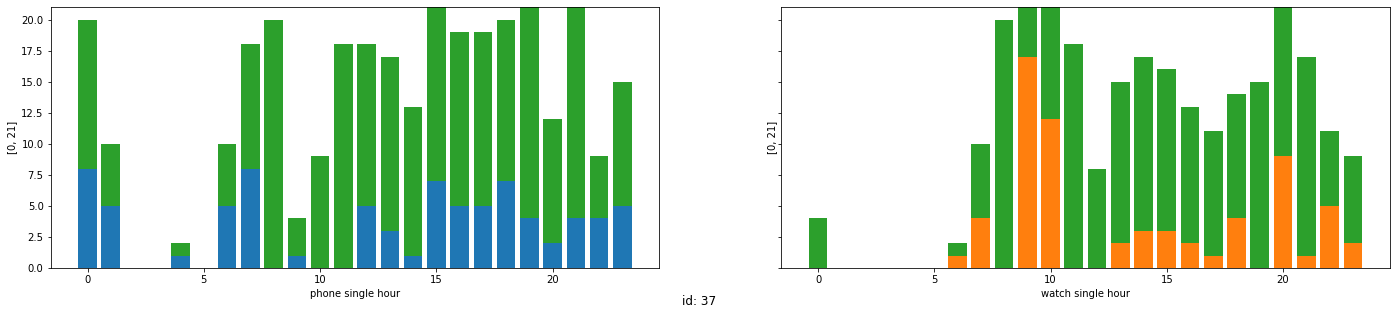

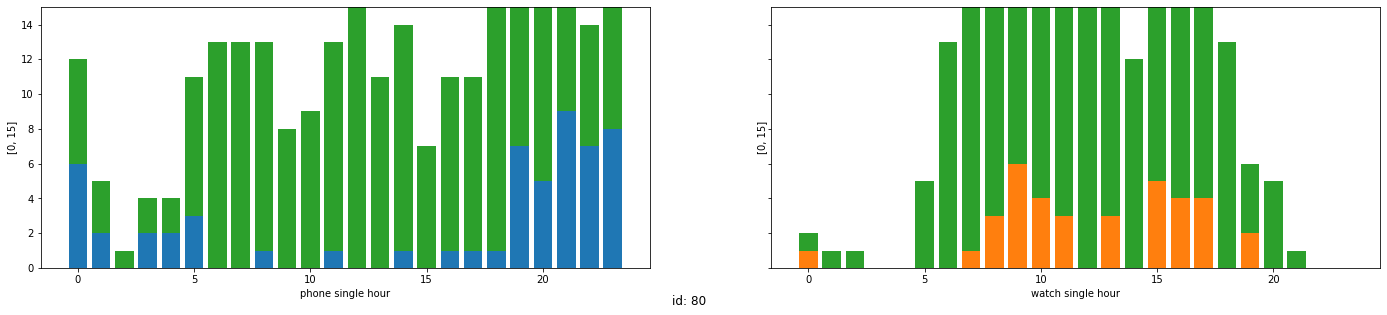

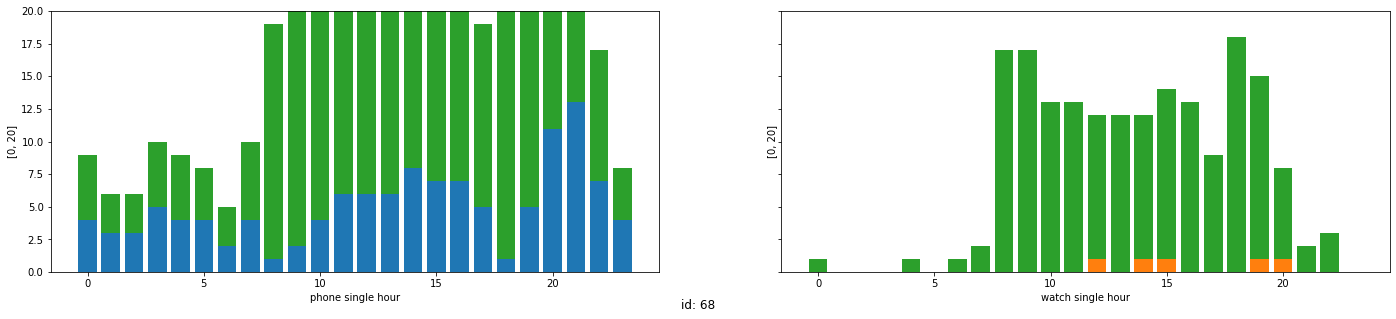

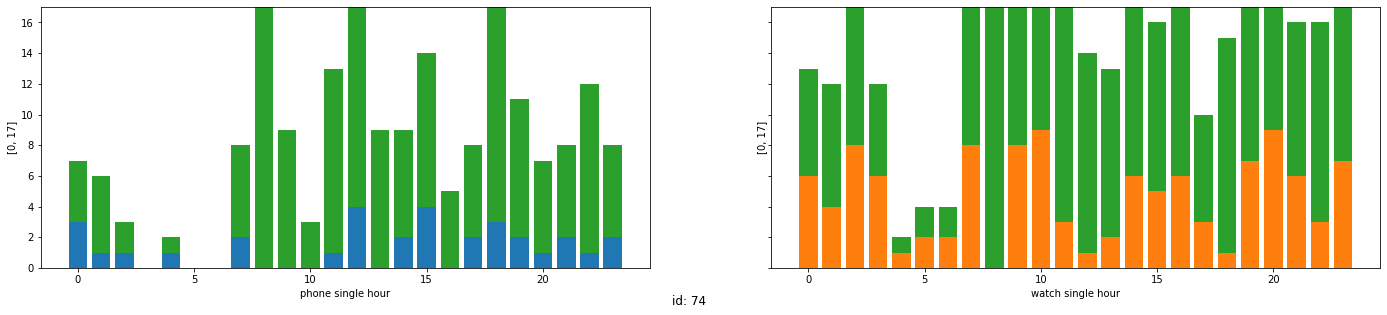

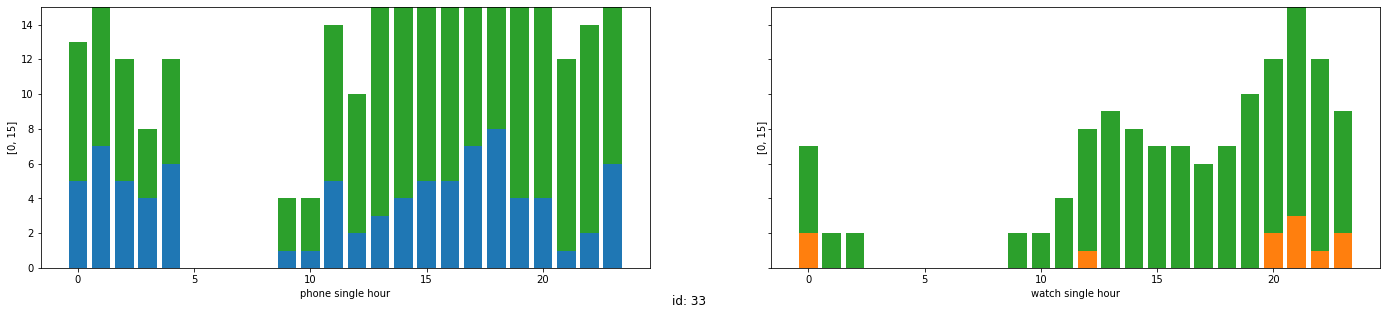

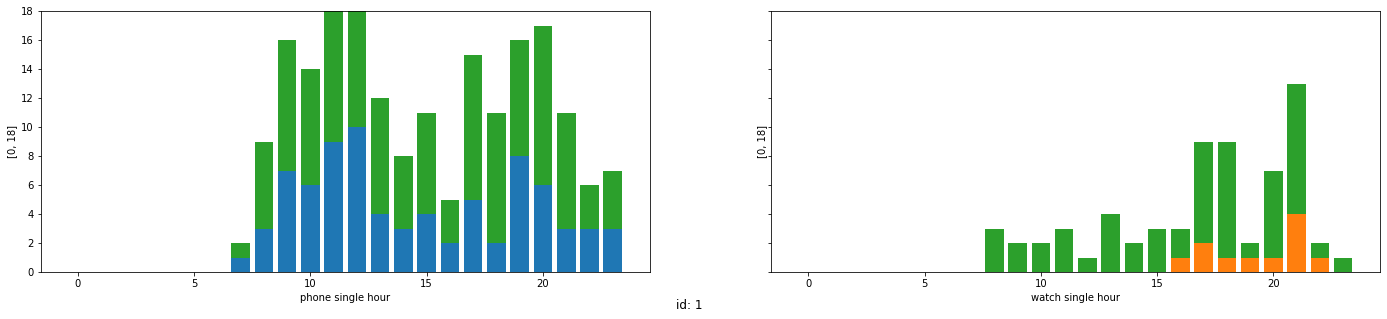

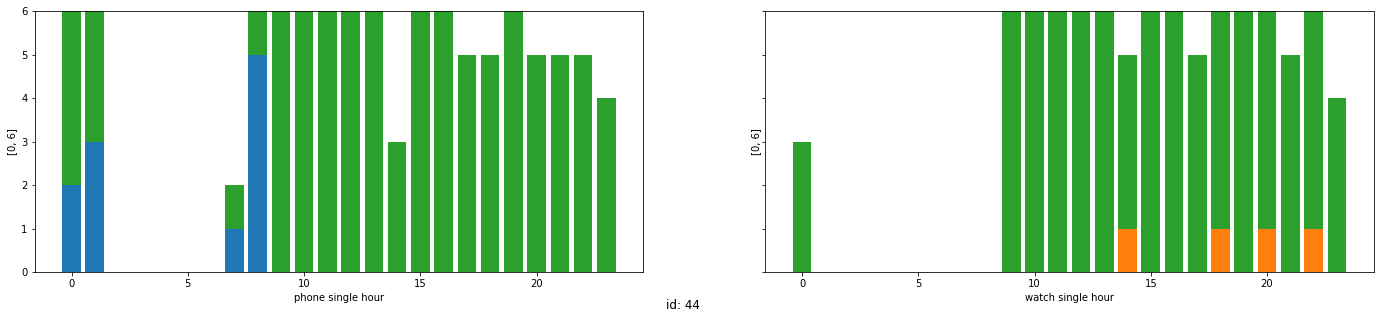

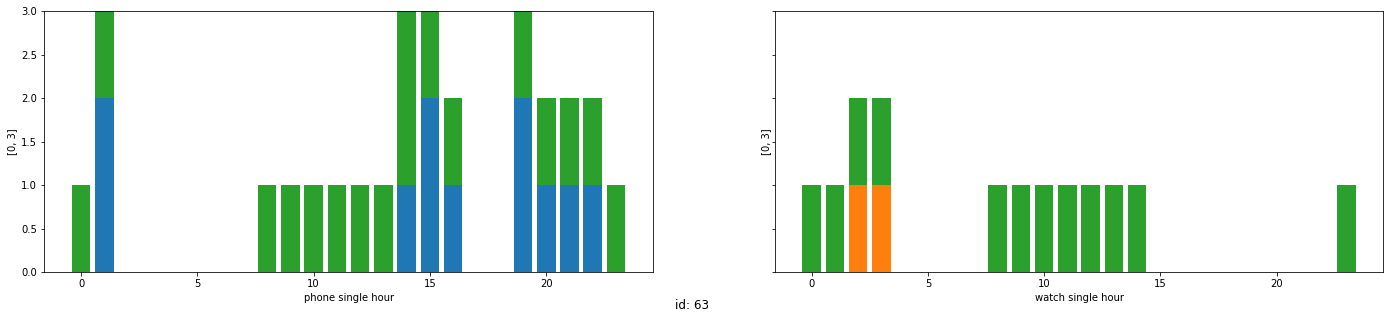

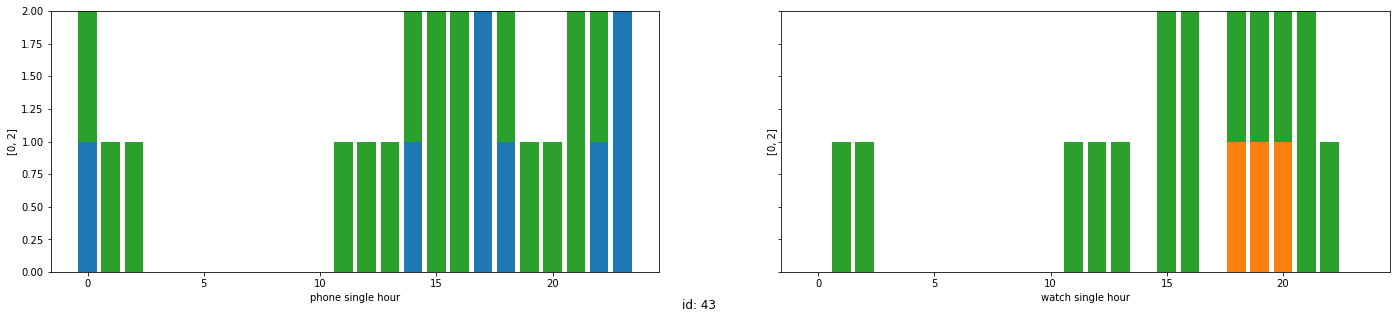

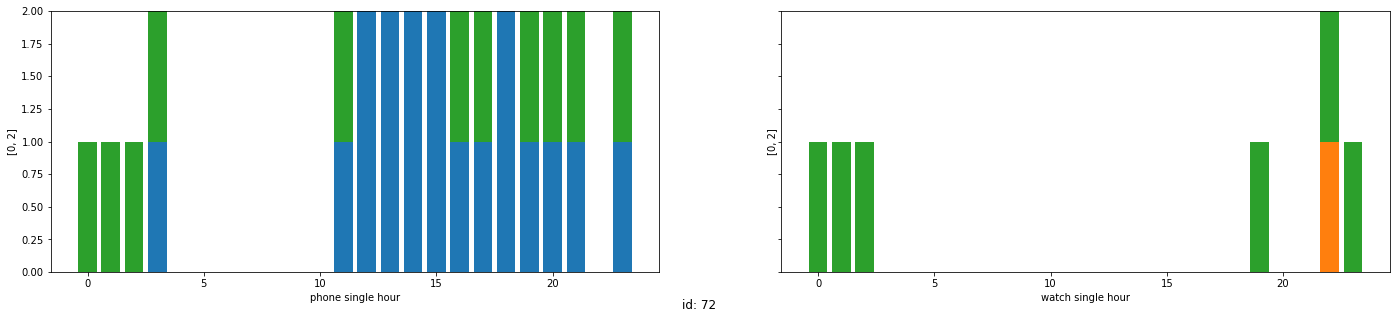

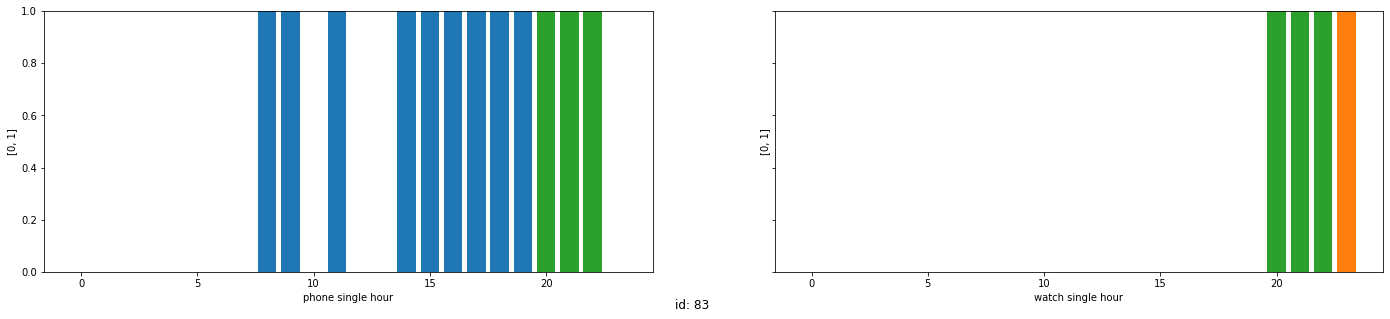

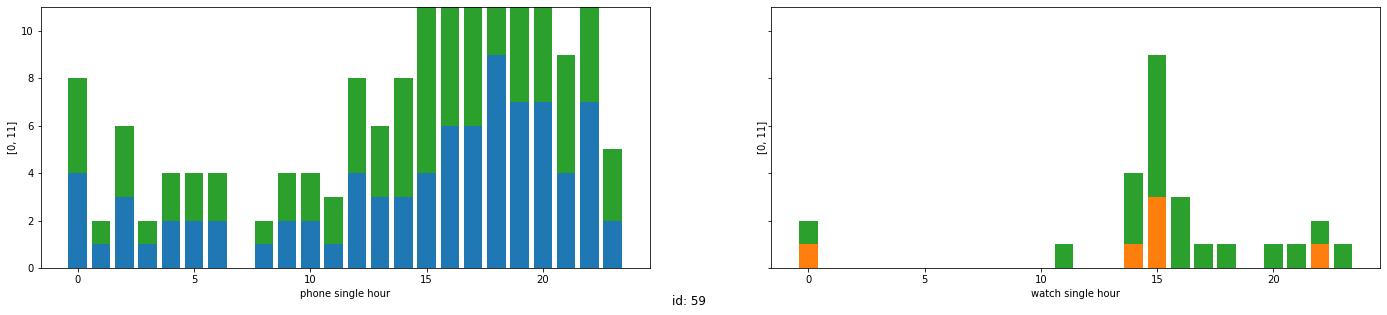

In [62]:
filtered = filterWearingDate(df)
filtered['run_ratio'] = [run/step if step> 0 else 0 for run, step in filtered[['run','step']].to_numpy()]
# filtered = filterWearingHour(filtered, ret_wearing = False)
filtered = filtered.query("weekday < 5")
single_hour = make_hourly(filtered)
for level in levels:
    print(f"{level}: ", end="")
    print(*[round(single_hour.query("level == @level")[step].to_numpy().sum()/total_diff*100,1) for step in ['pstep','wstep']])
print(f"total: ", end="")
print(*[round(single_hour[step].to_numpy().sum()/total_diff*100,1) for step in ['pstep','wstep']])
for id in users:
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 4.8), sharex = True, sharey= 'row')
    tmp= single_hour.query("uid == @id")
    for idx, btype in enumerate(["phone","watch"]):
        hist, _ = np.histogram(tmp.query(f"{btype[0]}ratio == 1")['hour'], bins = np.arange(25)-.5)
        both, _ = np.histogram(tmp.query(f"{btype[0]}step > 0 or bstep > 0")['hour'], bins = np.arange(25)-.5)
        axes[idx].bar(x = np.arange(24), height = hist, bottom = 0, color = color[btype])
        axes[idx].bar(x = np.arange(24), height = both, bottom = hist, color = color['both'])
        axes[idx].set_xlabel(f"{btype} single hour")
        axes[idx].set_ylabel([0,len(set(tmp['date']))])
        axes[idx].set_ylim([0,len(set(tmp['date']))])
    fig.supxlabel(f"id: {id}")
    plt.show()
    plt.close()

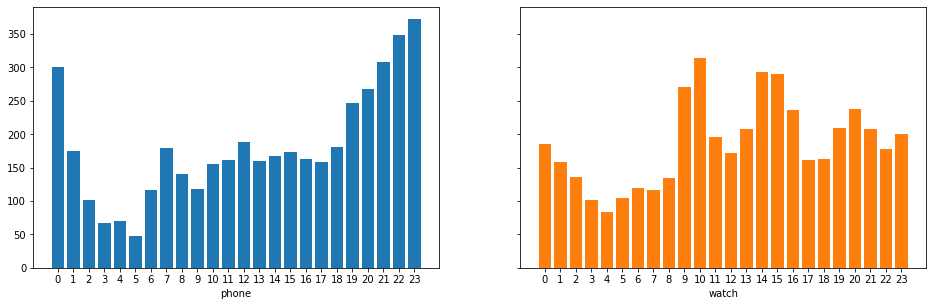

In [76]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 4.8), sharex = True, sharey= 'row')
for idx, btype in enumerate(["phone","watch"]):
    hist, _ = np.histogram(single_hour.query(f"{btype[0]}ratio == 1")['hour'], bins = np.arange(25)-.5)
    axes[idx].bar(x=np.arange(24), height = hist, bottom = 0, color = color[btype])
    axes[idx].set_xticks(range(24))
    axes[idx].set_xlabel(btype)

In [37]:
def show_user_bout_ratio(df_, save_name):
    btypes = ["both", "phone", "watch"]
    nrows, ncols = 1, 1
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize =(6.4*2.5*ncols, 4.8 * nrows), sharey = True)
    data = getBoutRatio(df_, normalize = False).sort_index(level =0, key= lambda x: [users.index(user) for user in x.to_numpy()])
    bottom = np.zeros(n_user)
    for btype in btypes:
        ax.bar(x = np.arange(n_user), height = data[btype[0]].to_numpy(), bottom = bottom, label = btype, color = color[btype])
        bottom += data[btype[0]].to_numpy()
    ax.set_xticks(np.arange(n_user))
    ax.set_xticklabels(users,  rotation= 90)
    ax.set_xlabel(save_name)
    ax.set_ylim([0,700000])
    plt.tight_layout()
    # plt.savefig(f"{save_name}.png",facecolor = 'white', transparent = False)
    plt.show()

39.3
29.8


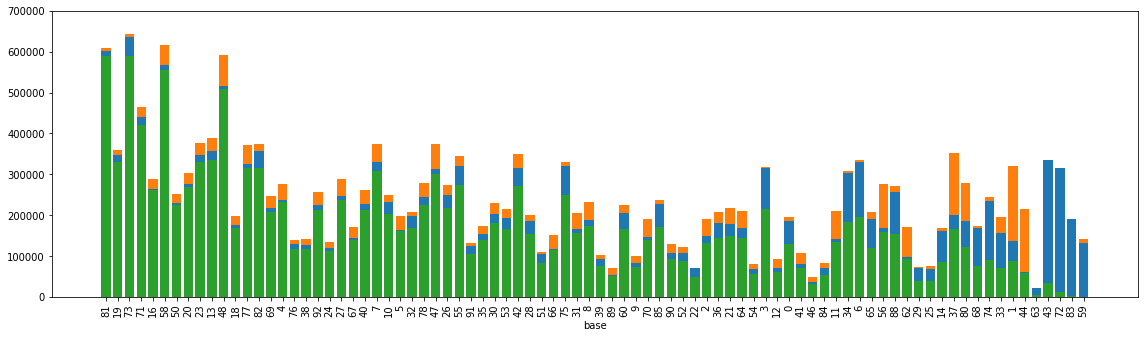

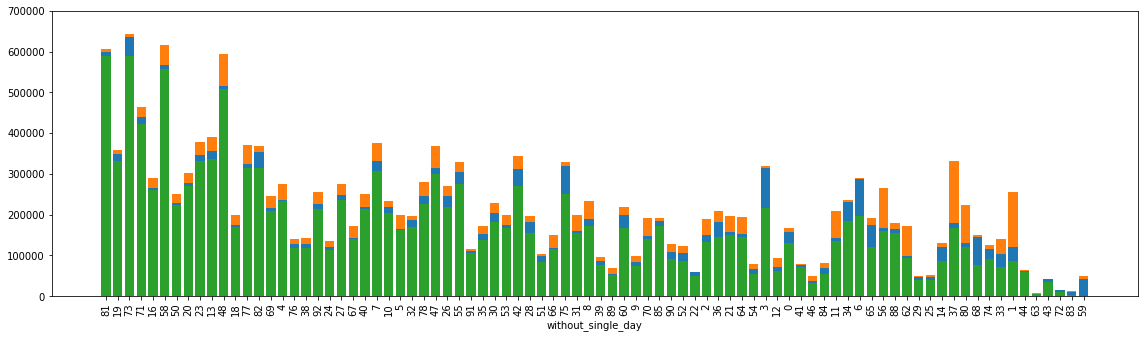

18.3
26.7


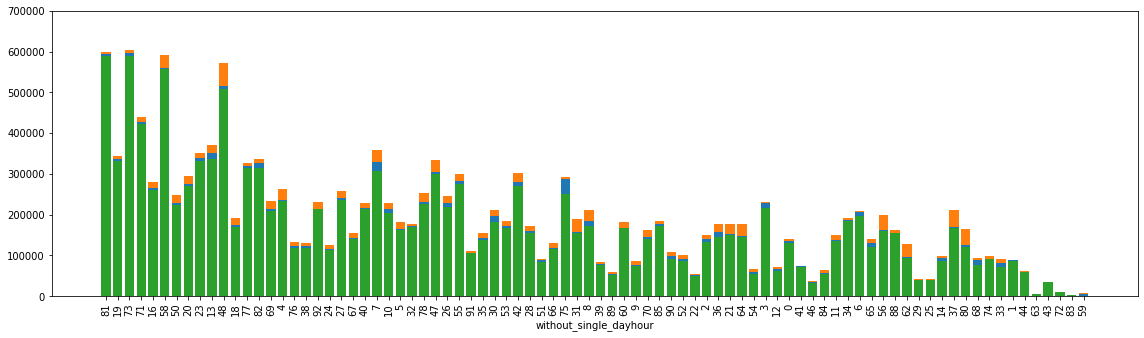

5.5
13.3
5.1
11.0


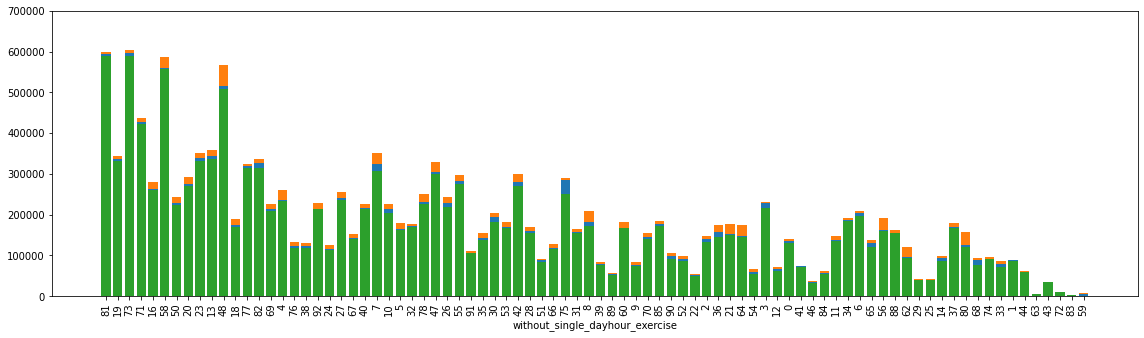

In [65]:
total_diff = np.sum(np.abs(df['pstep'] - df['wstep']))
phone = np.sum(df.query("btype=='p'")['step'])
watch = np.sum(df.query("btype=='w'")['step'])
print(round(phone/total_diff*100,1))
print(round(watch/total_diff*100,1))

show_user_bout_ratio(df, "base")

filtered = filterWearingDate(df)
show_user_bout_ratio(filtered, "without_single_day")
phone = np.sum(filtered.query("btype=='p'")['step'])
watch = np.sum(filtered.query("btype=='w'")['step'])
print(round(phone/total_diff*100,1))
print(round(watch/total_diff*100,1))

filtered = filterWearingHour(filtered)
show_user_bout_ratio(filtered, "without_single_dayhour")
phone = np.sum(filtered.query("btype=='p'")['step'])
watch = np.sum(filtered.query("btype=='w'")['step'])
print(round(phone/total_diff*100,1))
print(round(watch/total_diff*100,1))


filtered['run_ratio'] = [run/step if step> 0 else 0 for run, step in filtered[['run','step']].to_numpy()]
filtered = filtered.query("run_ratio < .05 or btype =='b'")
phone = np.sum(filtered.query("btype=='p'")['step'])
watch = np.sum(filtered.query("btype=='w'")['step'])
print(round(phone/total_diff*100,1))
print(round(watch/total_diff*100,1))
show_user_bout_ratio(filtered, "without_single_dayhour_exercise")


In [66]:
data = getBoutRatio(filtered, normalize = True)
threshold = .95
statement = ""
n_trust = [0,0]
for idx, btype in enumerate(['phone','watch']):
    n_trust[idx] = np.sum((data[btype[0]].to_numpy() + data['b'].to_numpy() ) > .95)
    statement += f"{btype} is coverable for {btype}: {n_trust[idx]}({round(n_trust[idx]/n_user*100,1)}%), " 
n_coverable = np.sum(((data['p'].to_numpy() + data['b'].to_numpy() ) > .95) | ((data['w'].to_numpy() + data['b'].to_numpy() ) > .95))
statement += f"total {n_coverable}({round(n_coverable/n_user*100,1)}%)"
print(statement)

phone is coverable for phone: 32(38.1%), watch is coverable for watch: 72(85.7%), total 76(90.5%)
